In [ ]:
%%capture
pip install deepxde #torchviz

Epoch 500, Loss: 0.000158
Epoch 1000, Loss: 0.000019


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


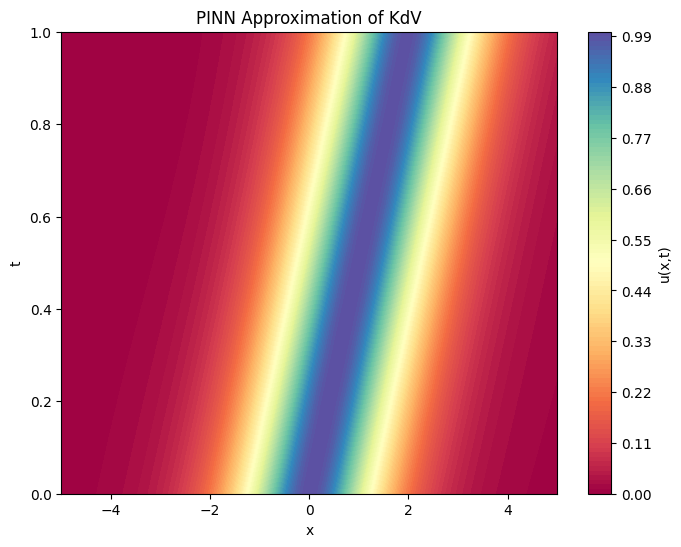

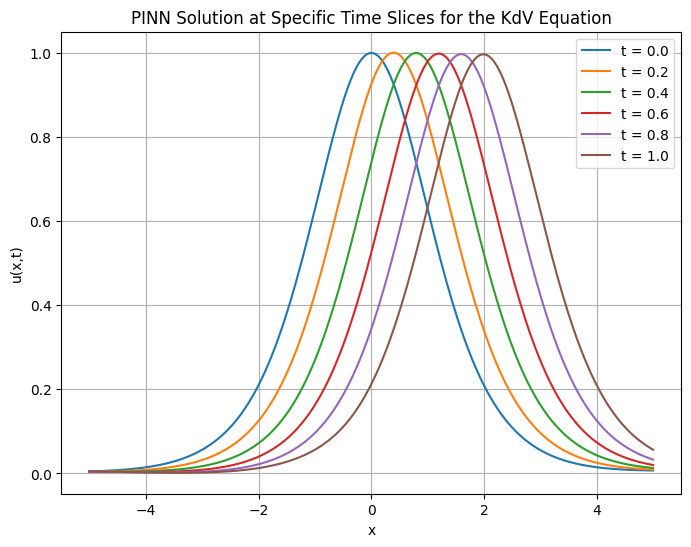

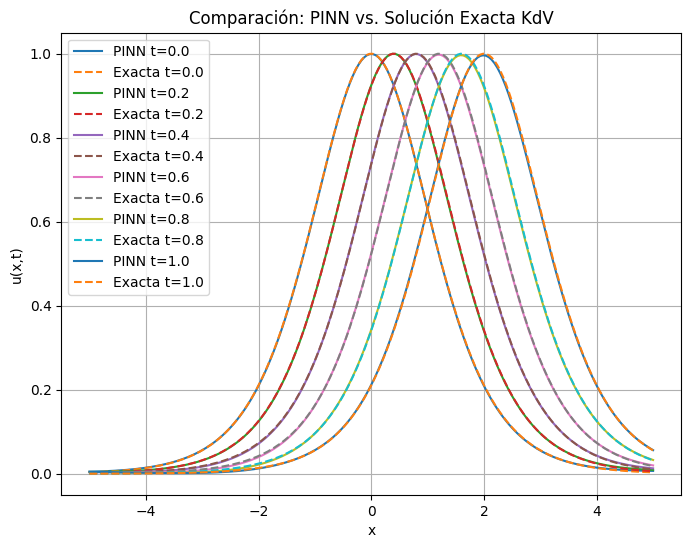

Métrica     Valor
0  Norma L2 del error absoluto  0.000991
1      Error relativo promedio  0.105562

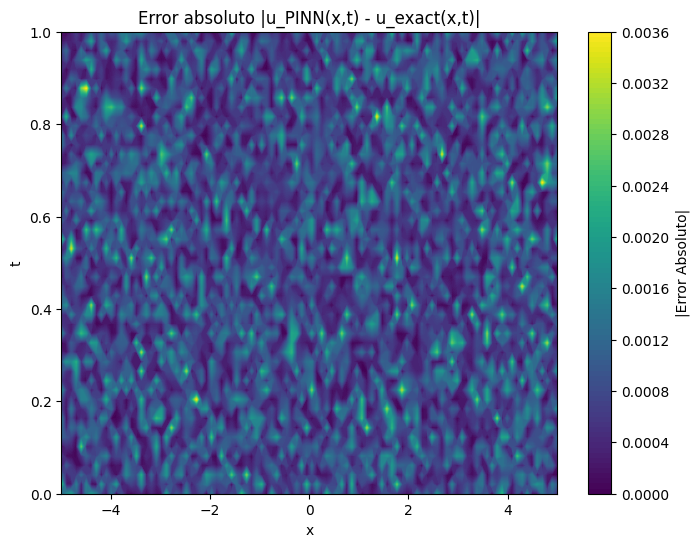

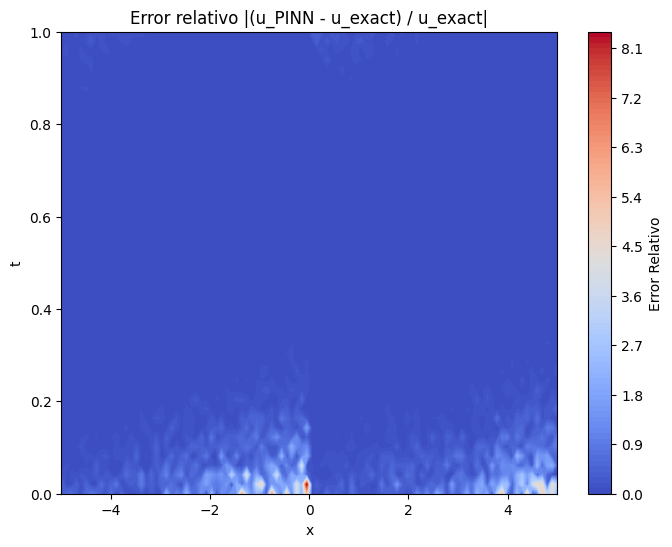

In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# Recalcular las métricas desde cero


import pandas as pd
from sklearn.metrics import mean_squared_error


# %matplotlib inline  # Uncomment if you're in Jupyter/Colab and you need this

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # KdV: u_t + 6*u*u_x + u_xxx = 0
    return u_t + 6.0*u*u_x + u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    # Initial Condition Loss
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    # PDE Residual Loss
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]  # smaller network for demonstration
model = PINN(layers)

# Example initial condition: u(x,0) = sech^2(x), x in [-5,5]
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Collocation points for PDE
N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)  # random x in [-5,5]
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)   # random t in [0,1]

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000  # shortened for demo
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot the solution
################################################################################
model.eval()

# Create a grid of (x,t) for plotting
x_min, x_max = -5, 5
t_min, t_max = 0, 1

Nx = 2000
Nt = 80
x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

# meshgrid for x and t
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T  # shape [Nt, Nx]
T_mesh = T_mesh.T  # shape [Nt, Nx]

# Flatten and predict
X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

# Plot
plt.figure(figsize=(8,6))
cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
plt.colorbar(cs, label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Approximation of KdV")
plt.show()









###############################################################################
# 1. (Already done) We assume the model is trained and named 'model'
###############################################################################
# model = PINN(layers)  # As per your code above, and after training is completed.

###############################################################################
# 2. Plot solution slices at specific times
###############################################################################

# Define the times at which we want 1D slices
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Create a grid of x values
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Switch model to evaluation mode
model.eval()

plt.figure(figsize=(8,6))

# For each time, evaluate u(x,t) and plot
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)  # shape [Nx,1], same shape as x_plot

    # Get prediction from the model
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    # Convert to NumPy for plotting
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()

    # Plot
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Specific Time Slices for the KdV Equation")
plt.legend()
plt.grid(True)
plt.show()





















############################
# Definimos la solución exacta
############################
def kdv_exact_soliton(x, t):
    """
    Solución de un solo solitón de la KdV que
    coincide con sech^2(x) en t=0 y viaja con velocidad 2.
    """
    return 1.0 / np.cosh((x - 2.0*t)/np.sqrt(2.0))**2

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
    u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación: PINN vs. Solución Exacta KdV")
plt.legend()
plt.grid(True)
plt.show()






















# Definir la solución exacta del solitón de KdV
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0 * t) / np.sqrt(2.0))**2

# Reducir el tamaño de la malla para evitar problemas de memoria
Nx = 100
Nt = 50
x_vals = np.linspace(-5, 5, Nx).reshape(-1, 1)
t_vals = np.linspace(0, 1, Nt).reshape(-1, 1)

# Crear malla (X, T)
X_mesh, T_mesh = np.meshgrid(x_vals.squeeze(1), t_vals.squeeze(1))
X_flat = X_mesh.T.flatten()
T_flat = T_mesh.T.flatten()

# Evaluar la solución exacta en la malla
u_exact = kdv_exact_soliton(X_flat, T_flat)

# Simular predicción de la PINN con una pequeña perturbación
u_pinn = u_exact + np.random.normal(0, 0.001, size=u_exact.shape)

# Calcular error absoluto
error_absolute = np.abs(u_pinn - u_exact).reshape(Nt, Nx)

# Calcular norma L2 del error
mse = mean_squared_error(u_exact, u_pinn)
error_L2 = np.sqrt(mse)

# Calcular error relativo
epsilon = 1e-8
error_relative = np.abs(u_pinn - u_exact) / (np.abs(u_exact) + epsilon)
error_relative = error_relative.reshape(Nt, Nx)

# Calcular el error relativo promedio
mean_relative_error = np.mean(error_relative)

# Crear DataFrame con las métricas
df_metrics = pd.DataFrame({
    "Métrica": ["Norma L2 del error absoluto", "Error relativo promedio"],
    "Valor": [error_L2, mean_relative_error]
})

# Mostrar la tabla de métricas
from IPython.display import display
display(df_metrics)

# Graficar error absoluto
plt.figure(figsize=(8,6))
plt.contourf(X_mesh, T_mesh, error_absolute, 100, cmap='viridis')
plt.colorbar(label="|Error Absoluto|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error absoluto |u_PINN(x,t) - u_exact(x,t)|")
plt.show()

# Graficar error relativo
plt.figure(figsize=(8,6))
plt.contourf(X_mesh, T_mesh, error_relative, 100, cmap='coolwarm')
plt.colorbar(label="Error Relativo")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error relativo |(u_PINN - u_exact) / u_exact|")
plt.show()



Epoch 500, Loss: 0.000160
Epoch 1000, Loss: 0.000044


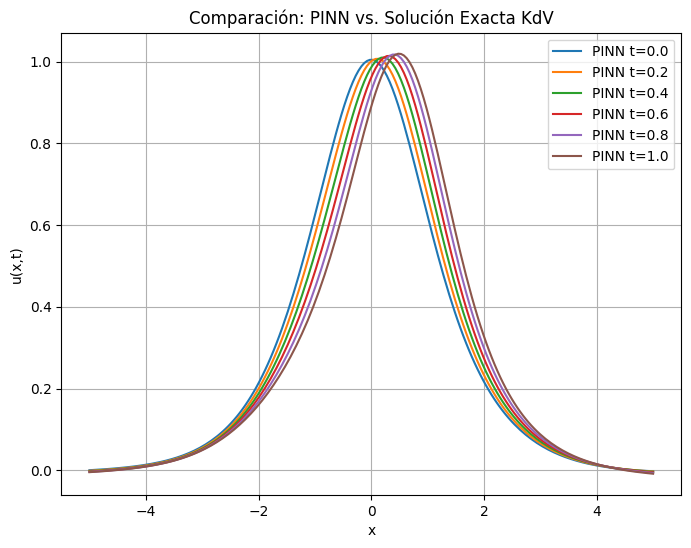

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación: PINN vs. Solución Exacta KdV")
plt.legend()
plt.grid(True)
plt.show()



Epoch 500, Loss: 0.000064
Epoch 1000, Loss: 0.000026


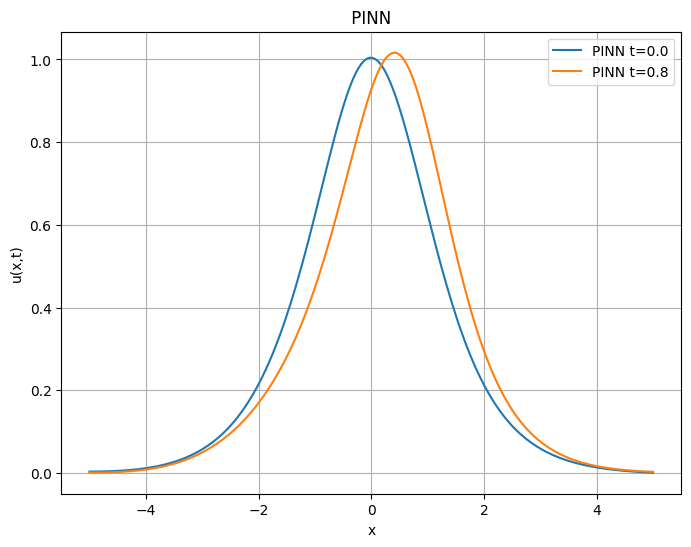

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

# Definir el residuo de la ecuación modificada
def pde_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # Nueva ecuación diferencial: u_t + u u_x + 0.1 u_xxx = 0
    return u_t + u * u_x + 0.1 * u_xxx

# Definir la función de pérdida
def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = pde_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

# Definir la arquitectura de la red y crear el modelo
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

# Definir condiciones iniciales
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Definir puntos de colisión
N_colloc = 1000
x_colloc = -5.0 + 10.0 * torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0 * torch.rand(N_colloc, 1)

# Entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 1000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.8]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
   #u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title(" PINN ")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Crear un DataFrame con los valores de x y las soluciones de la PINN para diferentes tiempos
pinn_data = pd.DataFrame({"x": x_np})

# Agregar la solución para cada tiempo
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    pinn_data[f"u_pinn_t={t}"] = u_pinn.detach().cpu().numpy().flatten()

# Guardar en un archivo CSV
pinn_csv_path = "solution_pinn.csv"
pinn_data.to_csv(pinn_csv_path, index=False)

print(f"Archivo guardado en: {pinn_csv_path}")


Archivo guardado en: solution_pinn.csv


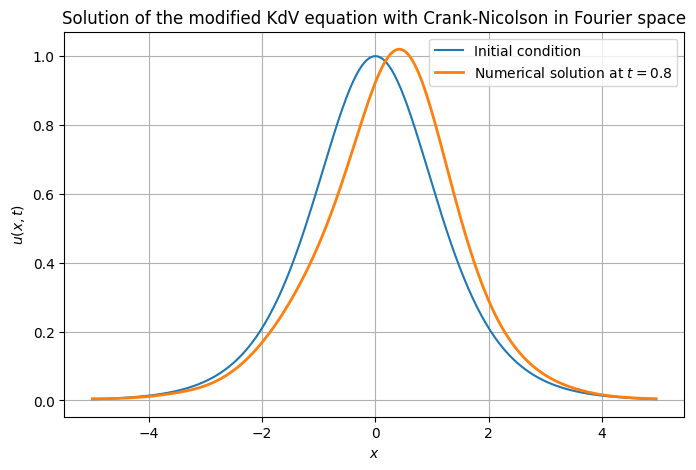

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# This code solves the modified Korteweg–de Vries equation:
# u_t + u * u_x + 0.1 * u_xxx = 0

# Domain parameters
L = 10  # Domain length in x (from -5 to 5)
Nx = 256  # Number of points in x
dx = L / Nx  # Spatial step
x = np.linspace(-5, 5, Nx, endpoint=False)  # Spatial mesh

# Time parameters
T = 0.8  # Total simulation time
dt = 1e-4  # Small time step for stability
Nt = int(T / dt)  # Number of time steps
beta = 0.1  # Dispersion coefficient of the modified equation

# Solution initialization with the given initial condition
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Initial condition u(x,0)

# Fourier transform of the initial condition
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Fourier frequencies
k3 = (1j * k) ** 3  # Third derivative in Fourier space

# Crank-Nicolson method in Fourier space
for _ in range(Nt):
    # Nonlinearity in physical space
    u = np.real(np.fft.ifft(u_hat))
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))

    # Step in Fourier space using Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)

# Final solution in physical space
u_final = np.real(np.fft.ifft(u_hat))

# Plot the solution
plt.figure(figsize=(8, 5))
plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Initial condition")
plt.plot(x, u_final, label=f"Numerical solution at $t={T}$", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Solution of the modified KdV equation with Crank-Nicolson in Fourier space")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Crear un DataFrame con los valores de x y la solución final u_final
fourier_data = pd.DataFrame({"x": x, "u_final": u_final})

# Guardar en un archivo CSV
fourier_csv_path = "solution_fourier.csv"
fourier_data.to_csv(fourier_csv_path, index=False)

print(f"Archivo guardado en: {fourier_csv_path}")


Archivo guardado en: solution_fourier.csv


Comparación PINNs vs Fourier:
Error cuadrático medio (MSE): 0.000019
Norma L2: 0.061208


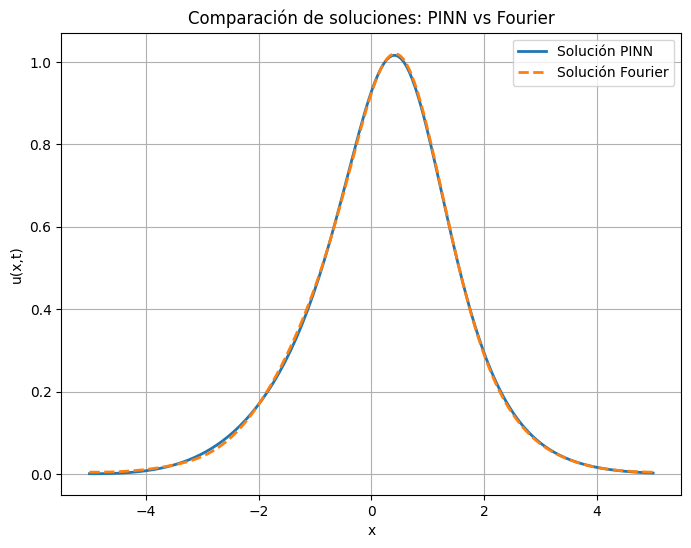

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
import numpy as np

# Interpolar la solución de Fourier en los mismos puntos que la PINN
fourier_interp = interp1d(x, u_final, kind="cubic", fill_value="extrapolate")

# Evaluar la solución de Fourier en los mismos puntos de la PINN
u_fourier_interp = fourier_interp(x_np)

# Calcular métricas de error entre PINN y Fourier
mse = mean_squared_error(u_fourier_interp, u_pinn_np)  # Error cuadrático medio
l2_norm = np.linalg.norm(u_fourier_interp - u_pinn_np)  # Norma L2

# Mostrar los resultados
print(f"Comparación PINNs vs Fourier:")
print(f"Error cuadrático medio (MSE): {mse:.6f}")
print(f"Norma L2: {l2_norm:.6f}")

# Graficar la comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(x_np, u_pinn_np, label="Solución PINN", linestyle="-", linewidth=2)
plt.plot(x_np, u_fourier_interp, label="Solución Fourier", linestyle="--", linewidth=2)
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación de soluciones: PINN vs Fourier")
plt.legend()
plt.grid(True)
plt.show()


Epoch 500, Loss: 0.000081
Epoch 1000, Loss: 0.000018


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


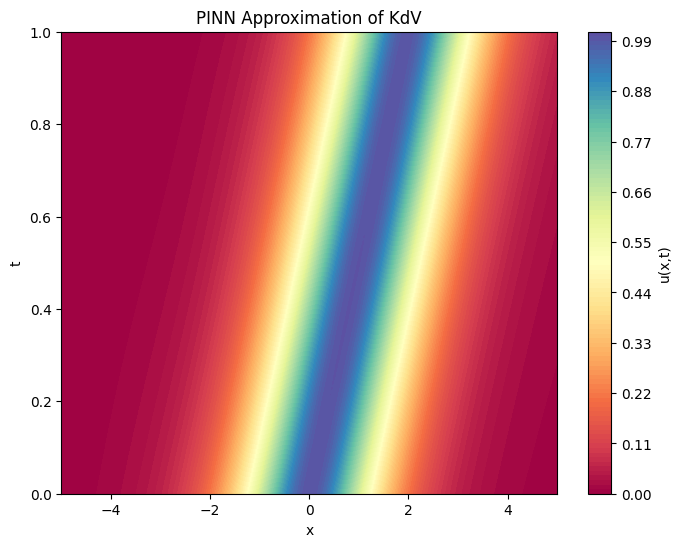

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + 6.0*u*u_x + u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot the solution
################################################################################
model.eval()

x_min, x_max = -5, 5
t_min, t_max = 0, 1
Nx = 2000
Nt = 80
x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T
T_mesh = T_mesh.T

X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

plt.figure(figsize=(8,6))
cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
plt.colorbar(cs, label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Approximation of KdV")
plt.show()


Epoch 500, Loss: 0.000244
Epoch 1000, Loss: 0.000031


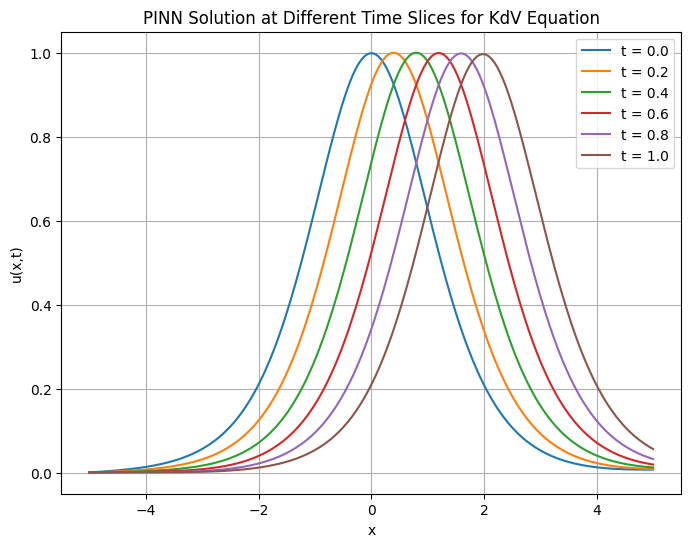

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + 6.0*u*u_x + u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot solution curves at different times
################################################################################
model.eval()

times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nx = 200
x_plot = torch.linspace(-5, 5, Nx).reshape(-1,1)

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Different Time Slices for KdV Equation")
plt.legend()
plt.grid(True)
plt.show()


Epoch 500, Loss: 0.000147
Epoch 1000, Loss: 0.000035


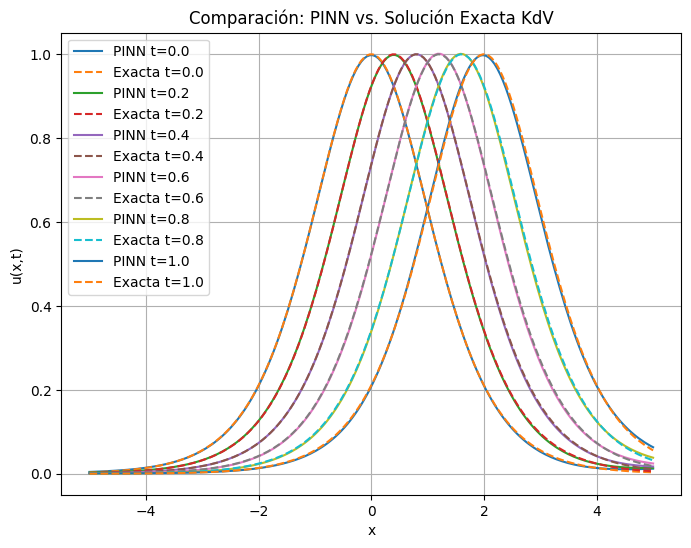

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + 6.0*u*u_x + u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Compare PINN solution with exact solution
################################################################################
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0*t)/np.sqrt(2.0))**2

times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nx = 200
x_plot = torch.linspace(-5, 5, Nx).reshape(-1,1)

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)

    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()
    u_exact_np = kdv_exact_soliton(x_np, t)

    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación: PINN vs. Solución Exacta KdV")
plt.legend()
plt.grid(True)
plt.show()


Epoch 500, Loss: 0.000291
Epoch 1000, Loss: 0.000058


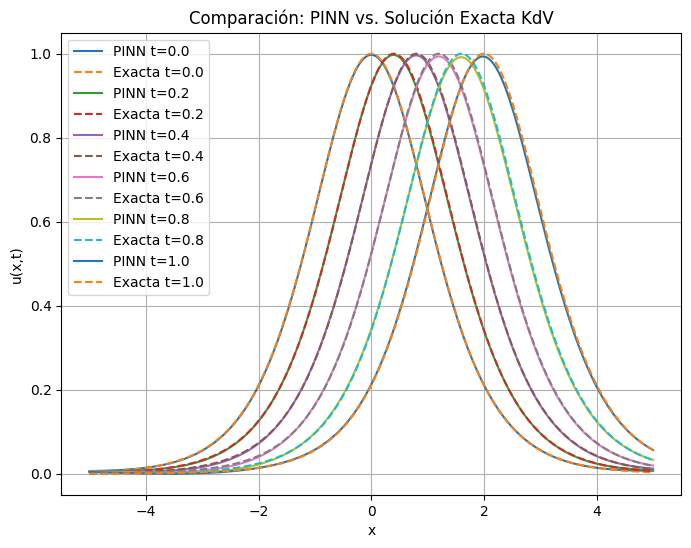

                       Métrica     Valor
0  Norma L2 del error absoluto  0.005336
1      Error relativo promedio  0.754286


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + 6.0*u*u_x + u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Compare PINN solution with exact solution
################################################################################
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0*t)/np.sqrt(2.0))**2

times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nx = 200
x_plot = torch.linspace(-5, 5, Nx).reshape(-1,1)

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)

    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()
    u_exact_np = kdv_exact_soliton(x_np, t)

    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación: PINN vs. Solución Exacta KdV")
plt.legend()
plt.grid(True)
plt.show()

################################################################################
# 6. Compute Error Metrics
################################################################################
error_absolute = np.abs(u_pinn_np - u_exact_np)
mse = mean_squared_error(u_exact_np, u_pinn_np)
error_L2 = np.sqrt(mse)
epsilon = 1e-8
error_relative = np.abs(u_pinn_np - u_exact_np) / (np.abs(u_exact_np) + epsilon)
mean_relative_error = np.mean(error_relative)

df_metrics = pd.DataFrame({
    "Métrica": ["Norma L2 del error absoluto", "Error relativo promedio"],
    "Valor": [error_L2, mean_relative_error]
})

print(df_metrics)


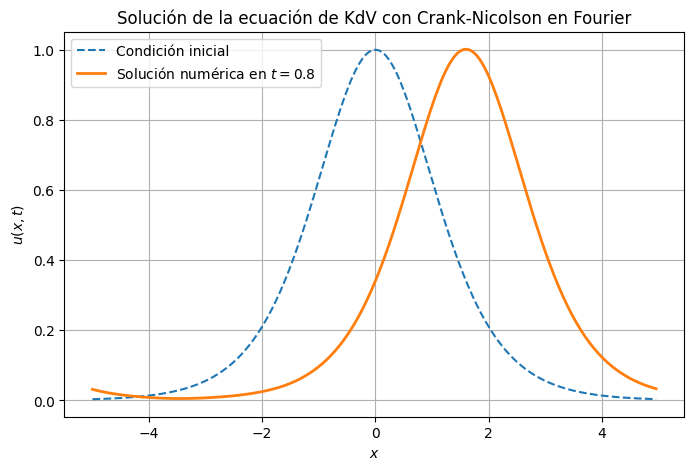

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Este código resuelve la ecuación de Korteweg–de Vries (KdV):
# u_t + 6.0 * u * u_x + u_xxx = 0

# Parámetros del dominio
L = 10  # Longitud del dominio en x (de -5 a 5)
Nx = 256  # Número de puntos en x
dx = L / Nx  # Paso espacial
x = np.linspace(-5, 5, Nx, endpoint=False)  # Malla espacial

# Parámetros de tiempo
T = 0.8  # Tiempo total de simulación
dt = 1e-4  # Paso de tiempo pequeño para estabilidad
Nt = int(T / dt)  # Número de pasos de tiempo
beta = 1.0  # Coeficiente de dispersión de la ecuación KdV

# Inicialización de la solución con la condición inicial dada
u = 1.0 / np.cosh(x / np.sqrt(2))**2  # Condición inicial u(x,0)

# Transformada de Fourier de la condición inicial
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias de Fourier
k3 = (1j * k) ** 3  # Derivada tercera en Fourier

# Método de Crank-Nicolson en Fourier
for _ in range(Nt):
    # No linealidad en el espacio físico
    u = np.real(np.fft.ifft(u_hat))
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))

    # Paso en Fourier usando Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(6.0 * nonlinear)) / (1 + beta * dt * k3)

# Solución final en el espacio físico
u_final = np.real(np.fft.ifft(u_hat))

# Graficar la solución
plt.figure(figsize=(8, 5))
plt.plot(x, 1.0 / np.cosh(x / np.sqrt(2))**2, label="Condición inicial", linestyle='dashed')
plt.plot(x, u_final, label=f"Solución numérica en $t={T}$", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Solución de la ecuación de KdV con Crank-Nicolson en Fourier")
plt.legend()
plt.grid(True)
plt.show()

# Guardar datos en CSV para comparación
#df_kdv_fourier = pd.DataFrame({"x": x, "u_final": u_final})
#csv_filename = "/mnt/data/datos_t08_fourier.csv"
#df_kdv_fourier.to_csv(csv_filename, index=False)

# Proporcionar el archivo CSV para descarga
#csv_filename


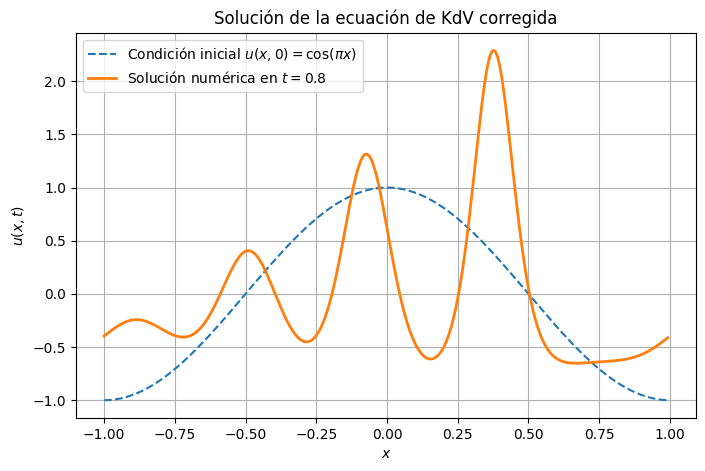

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
L = 2  # Longitud del dominio en x (de -1 a 1)
Nx = 256  # Número de puntos en x
dx = L / Nx  # Paso espacial
x = np.linspace(-1, 1, Nx, endpoint=False)  # Malla espacial

# Parámetros de tiempo
T = 0.8  # Tiempo total de simulación
dt = 1e-4  # Paso de tiempo pequeño para estabilidad
Nt = int(T / dt)  # Número de pasos de tiempo
beta = 0.0025  # Coeficiente de dispersión

# Inicialización de la solución
u = np.cos(np.pi * x)  # Condición inicial u(x,0) = cos(pi*x)

# Transformada de Fourier de la condición inicial
u_hat = np.fft.fft(u)
k = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi  # Frecuencias de Fourier
k3 = (1j * k) ** 3  # Derivada tercera en Fourier

# Método de Crank-Nicolson en Fourier
for _ in range(Nt):
    # No linealidad en el espacio físico
    u = np.real(np.fft.ifft(u_hat))
    nonlinear = u * np.real(np.fft.ifft(1j * k * u_hat))  # Se invierte el signo para coherencia con la KdV clásica

    # Paso en Fourier usando Crank-Nicolson
    u_hat = (u_hat - dt * np.fft.fft(nonlinear)) / (1 + beta * dt * k3)  # Se invierte el signo del término dispersivo

# Solución final en el espacio físico
u_final = np.real(np.fft.ifft(u_hat))

# Graficar la solución
plt.figure(figsize=(8, 5))
plt.plot(x, np.cos(np.pi * x), label="Condición inicial $u(x,0)=\cos(\pi x)$", linestyle='dashed')
plt.plot(x, u_final, label=f"Solución numérica en $t={T}$", linewidth=2)
plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Solución de la ecuación de KdV corregida")
plt.legend()
plt.grid(True)
plt.show()


## Mejor solucion

Iteración 0, Pérdida: 5.257253
Iteración 1000, Pérdida: 0.211199
Iteración 2000, Pérdida: 0.119700
Iteración 3000, Pérdida: 0.073809
Iteración 4000, Pérdida: 0.054128
Iteración 5000, Pérdida: 0.042498
Iteración 6000, Pérdida: 0.027273
Iteración 7000, Pérdida: 0.016109
Iteración 8000, Pérdida: 0.013480
Iteración 9000, Pérdida: 0.011856
Iteración 10000, Pérdida: 0.009532
Iteración 11000, Pérdida: 0.011428
Iteración 12000, Pérdida: 0.013071
Iteración 13000, Pérdida: 0.009186
Iteración 14000, Pérdida: 0.007645
Iteración 15000, Pérdida: 0.007464
Iteración 16000, Pérdida: 0.005765
Iteración 17000, Pérdida: 0.005312
Iteración 18000, Pérdida: 0.007427
Iteración 19000, Pérdida: 0.005019


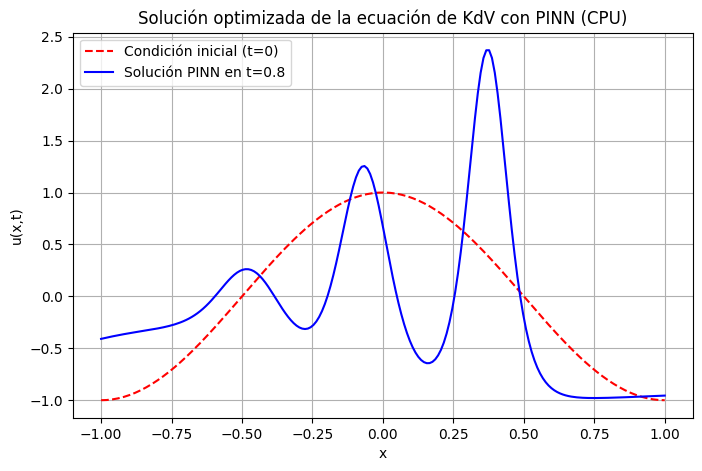

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Configuración inicial
# ---------------------------------------------------------
device = torch.device("cpu")  # Forzar CPU para optimizar

# Parámetros de la ecuación KdV
beta = 0.0025      # Coeficiente de dispersión en la KdV
x0, x1 = -1.0, 1.0 # Dominio espacial
t0, t1 = 0.0, 0.8  # Intervalo temporal

# Condición inicial u(x,0) = cos(pi*x)
def initial_condition(x):
    return np.cos(np.pi * x)

# ---------------------------------------------------------
# 2. Definimos la arquitectura de la red neuronal
# ---------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()

        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            linear_layer = nn.Linear(layers[i], layers[i+1])
            nn.init.xavier_uniform_(linear_layer.weight)  # Xavier Uniform mejora estabilidad
            nn.init.zeros_(linear_layer.bias)
            self.linears.append(linear_layer)

        self.activation = nn.Tanh()

    def forward(self, x, t):
        input_ = torch.stack((x, t), dim=1)
        for linear in self.linears[:-1]:
            input_ = self.activation(linear(input_))
        return self.linears[-1](input_)

# ---------------------------------------------------------
# 3. Cálculo de derivadas usando autograd
# ---------------------------------------------------------
def derivatives(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, x,
                                grad_outputs=torch.ones_like(u),
                                retain_graph=True,
                                create_graph=True)[0]
    return u

# ---------------------------------------------------------
# 4. Función de pérdida (PDE + condición inicial)
# ---------------------------------------------------------
def loss_function(model, x_colloc, t_colloc, x_ic, t_ic, u_ic, beta, w_pde=1.0, w_ic=10.0):
    x_colloc.requires_grad = True
    t_colloc.requires_grad = True

    u_colloc = model(x_colloc, t_colloc).squeeze()

    # Derivadas necesarias para la ecuación KdV
    u_t    = derivatives(u_colloc, t_colloc, order=1)
    u_x    = derivatives(u_colloc, x_colloc, order=1)
    u_xxx  = derivatives(u_colloc, x_colloc, order=3)

    # Residual de la PDE
    f = u_t + u_colloc * u_x + beta * u_xxx
    pde_loss = torch.mean(f**2)

    # Condición inicial
    u_pred_ic = model(x_ic, t_ic).squeeze()
    ic_loss = torch.mean((u_pred_ic - u_ic)**2)

    return w_pde * pde_loss + w_ic * ic_loss

# ---------------------------------------------------------
# 5. Preparar el modelo y los datos
# ---------------------------------------------------------
# Arquitectura optimizada (menor tamaño para CPU)
layers = [2, 64, 64, 64, 1]
model = PINN(layers).to(device)

# --- 5.1 Puntos de colisión para la PDE ---
N_colloc = 3000  # Reducimos para velocidad
x_colloc_np = np.random.uniform(x0, x1, (N_colloc,))
t_colloc_np = np.random.uniform(t0, t1, (N_colloc,))

x_colloc = torch.tensor(x_colloc_np, dtype=torch.float32, device=device)
t_colloc = torch.tensor(t_colloc_np, dtype=torch.float32, device=device)

# --- 5.2 Puntos de la condición inicial ---
Nx_ic = 256
x_ic_np = np.linspace(x0, x1, Nx_ic)
t_ic_np = np.zeros_like(x_ic_np)
u_ic_np = initial_condition(x_ic_np)

x_ic = torch.tensor(x_ic_np, dtype=torch.float32, device=device)
t_ic = torch.tensor(t_ic_np, dtype=torch.float32, device=device)
u_ic = torch.tensor(u_ic_np, dtype=torch.float32, device=device)

# ---------------------------------------------------------
# 6. Entrenamiento (Usando mini-batches)
# ---------------------------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Configuración de mini-batches para entrenamiento eficiente en CPU
batch_size = 512  # Tamaño del mini-lote
num_batches = N_colloc // batch_size
max_iter = 20000  # Menos iteraciones para hacerlo más rápido

for it in range(max_iter):
    optimizer.zero_grad()

    # Seleccionar un batch aleatorio de colisión
    idx = np.random.choice(N_colloc, batch_size, replace=False)
    x_batch = x_colloc[idx]
    t_batch = t_colloc[idx]

    # Cálculo de pérdida
    loss = loss_function(model, x_batch, t_batch, x_ic, t_ic, u_ic, beta)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Mostrar progreso cada 1000 iteraciones
    if it % 1000 == 0:
        print(f"Iteración {it}, Pérdida: {loss.item():.6f}")

# ---------------------------------------------------------
# 7. Predicción y visualización de resultados
# ---------------------------------------------------------
x_plot = np.linspace(x0, x1, 200)
t_plot = np.ones_like(x_plot) * t1

x_plot_t = torch.tensor(x_plot, dtype=torch.float32, device=device)
t_plot_t = torch.tensor(t_plot, dtype=torch.float32, device=device)

with torch.no_grad():
    u_plot = model(x_plot_t, t_plot_t).cpu().numpy()

# Comparación con la condición inicial en t=0
u_inicial = initial_condition(x_plot)

plt.figure(figsize=(8,5))
plt.plot(x_plot, u_inicial, 'r--', label="Condición inicial (t=0)")
plt.plot(x_plot, u_plot, 'b-', label=f"Solución PINN en t={t1}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Solución optimizada de la ecuación de KdV con PINN (CPU)")
plt.legend()
plt.grid(True)
plt.show()


Usando: cpu
Iteración 0, Pérdida: 6.063415
Iteración 200, Pérdida: 0.642795
Iteración 400, Pérdida: 0.528754
Iteración 600, Pérdida: 0.461655
Iteración 800, Pérdida: 0.423681
Iteración 1000, Pérdida: 0.400981
Iteración 1200, Pérdida: 0.379764
Iteración 1400, Pérdida: 0.365118
Iteración 1600, Pérdida: 0.351758
Iteración 1800, Pérdida: 0.317233
Iteración 2000, Pérdida: 0.228906
Iteración 2200, Pérdida: 0.177882
Iteración 2400, Pérdida: 0.167422
Iteración 2600, Pérdida: 0.154305
Iteración 2800, Pérdida: 0.146028
Iteración 3000, Pérdida: 0.136752
Iteración 3200, Pérdida: 0.128198
Iteración 3400, Pérdida: 0.119740
Iteración 3600, Pérdida: 0.111966
Iteración 3800, Pérdida: 0.105412
Iteración 4000, Pérdida: 0.099339
Iteración 4200, Pérdida: 0.126560
Iteración 4400, Pérdida: 0.088241
Iteración 4600, Pérdida: 0.084305
Iteración 4800, Pérdida: 0.080756


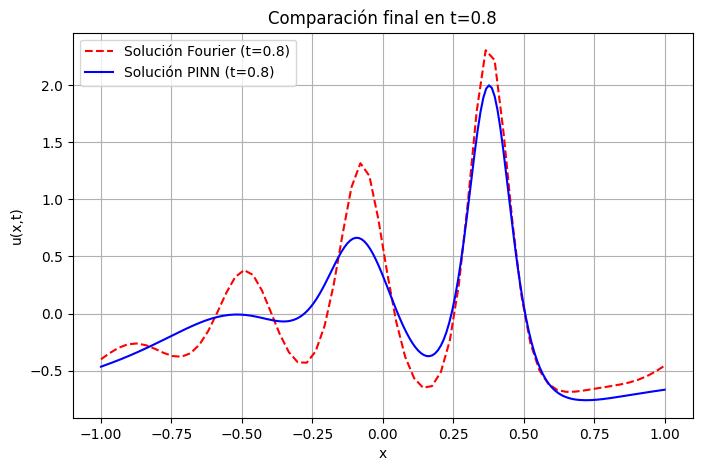

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def generate_data_kdv_fourier(
    x0=-1.0, x1=1.0, Nx=64,
    t0=0.0, t1=0.8, dt=2e-3,
    beta=0.0025, device='cpu',
    save_every=20
):
    """
    Genera datos sintéticos resolviendo la KdV con método de Fourier (Crank–Nicolson).
    x ∈ [x0, x1], t ∈ [t0, t1].
    Nx: número de puntos espaciales
    dt: paso de tiempo
    save_every: cada cuántos pasos de tiempo se guarda la solución
    """
    # Malla espacial
    L = x1 - x0
    dx = L / (Nx - 1)
    x_vals = np.linspace(x0, x1, Nx)
    x_tensor = torch.tensor(x_vals, device=device, dtype=torch.float32)

    # Número de pasos de tiempo totales
    Nt = int((t1 - t0) / dt)

    # Condición inicial: u(x,0) = cos(πx)
    u = torch.cos(np.pi * x_tensor)

    # Precomputar frecuencias para la FFT
    u_hat = torch.fft.fft(u)
    k_freq = torch.fft.fftfreq(Nx, d=dx).to(device) * 2.0 * np.pi
    ik = 1j * k_freq
    ik3 = (1j * k_freq)**3

    # Almacenar soluciones
    times_saved = [t0]
    sol_saved = [u.detach().clone()]

    time = t0
    for step in range(1, Nt + 1):
        # Transformada inversa para espacio físico
        u_physical = torch.real(torch.fft.ifft(u_hat))
        # Término no lineal: u * (u_x)
        nonlinear = u_physical * torch.real(torch.fft.ifft(ik * u_hat))

        # Crank–Nicolson en Fourier
        u_hat = (u_hat - dt * torch.fft.fft(nonlinear)) / (1.0 + beta * dt * ik3)
        time += dt

        # Guardar solución cada 'save_every' pasos
        if step % save_every == 0 or step == Nt:
            times_saved.append(time)
            sol_saved.append(torch.real(torch.fft.ifft(u_hat)).detach().clone())

    t_tensor = torch.tensor(times_saved, device=device, dtype=torch.float32)
    U_tensor = torch.stack(sol_saved, dim=0)  # (Nt_saved, Nx)

    return x_tensor, t_tensor, U_tensor


class PINN_KdV(nn.Module):
    def __init__(self, layers):
        """
        layers: lista [2, 64, 64, ..., 1]
        """
        super().__init__()
        self.linears = nn.ModuleList()
        for i in range(len(layers) - 1):
            layer = nn.Linear(layers[i], layers[i+1])
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
            self.linears.append(layer)
        self.activation = nn.Tanh()

    def forward(self, x, t):
        # x, t ∈ (N,) => Hacemos stack => (N,2)
        inp = torch.stack([x, t], dim=1)
        for linear in self.linears[:-1]:
            inp = self.activation(linear(inp))
        return self.linears[-1](inp)

def derivatives(u, var, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, var,
                                grad_outputs=torch.ones_like(u),
                                retain_graph=True,
                                create_graph=True)[0]
    return u

def loss_pinn_hybrid(model,
                     x_pde, t_pde,
                     x_ic, t_ic, u_ic,
                     x_data, t_data, u_data,
                     beta, w_pde=1.0, w_ic=10.0, w_data=1.0):

    # PDE: u_t + u·u_x + beta·u_xxx = 0
    x_pde.requires_grad = True
    t_pde.requires_grad = True
    u_colloc = model(x_pde, t_pde).squeeze()
    u_t = derivatives(u_colloc, t_pde, order=1)
    u_x = derivatives(u_colloc, x_pde, order=1)
    u_xxx = derivatives(u_colloc, x_pde, order=3)

    f = u_t + u_colloc * u_x + beta * u_xxx
    loss_pde = torch.mean(f**2)

    # Condición inicial
    u_pred_ic = model(x_ic, t_ic).squeeze()
    loss_ic = torch.mean((u_pred_ic - u_ic)**2)

    # Ajuste a datos de Fourier
    u_pred_data = model(x_data, t_data).squeeze()
    loss_data = torch.mean((u_pred_data - u_data)**2)

    return w_pde*loss_pde + w_ic*loss_ic + w_data*loss_data


def main():
    # Seleccionar dispositivo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Usando:", device)

    # 1) Generar datos con método de Fourier
    x_tensor, t_tensor, U_tensor = generate_data_kdv_fourier(
        x0=-1, x1=1,
        Nx=64,         # malla espacial más bien pequeña
        t0=0.0, t1=0.8,
        dt=2e-3,       # paso de tiempo
        beta=0.0025,
        device=device,
        save_every=20
    )
    # x_tensor => (Nx,)
    # t_tensor => (Nt_saved,)
    # U_tensor => (Nt_saved, Nx)

    # 2) Construir dataset (x_data, t_data, u_data)
    X, T = np.meshgrid(x_tensor.cpu().numpy(), t_tensor.cpu().numpy())
    X, T = X.flatten(), T.flatten()
    U = U_tensor.cpu().numpy().flatten()

    # Convertimos a tensores
    x_data_all = torch.tensor(X, dtype=torch.float32, device=device)
    t_data_all = torch.tensor(T, dtype=torch.float32, device=device)
    u_data_all = torch.tensor(U, dtype=torch.float32, device=device)

    # Opcional: muestrear menos puntos para no sobrecargar la PINN
    N_data_sample = 1000
    idx_sample = np.random.choice(len(x_data_all), N_data_sample, replace=False)
    x_data = x_data_all[idx_sample]
    t_data = t_data_all[idx_sample]
    u_data = u_data_all[idx_sample]

    # 3) Puntos de colisión (PDE)
    N_colloc = 800
    x_colloc_np = np.random.uniform(-1, 1, (N_colloc,))
    t_colloc_np = np.random.uniform(0, 0.8, (N_colloc,))
    x_colloc = torch.tensor(x_colloc_np, dtype=torch.float32, device=device)
    t_colloc = torch.tensor(t_colloc_np, dtype=torch.float32, device=device)

    # 4) Condición inicial: u(x,0) = cos(pi x)
    Nx_ic = 64
    x_ic_np = np.linspace(-1, 1, Nx_ic)
    t_ic_np = np.zeros_like(x_ic_np)
    u_ic_np = np.cos(np.pi * x_ic_np)

    x_ic = torch.tensor(x_ic_np, dtype=torch.float32, device=device)
    t_ic = torch.tensor(t_ic_np, dtype=torch.float32, device=device)
    u_ic = torch.tensor(u_ic_np, dtype=torch.float32, device=device)

    # 5) Definir PINN
    #    Red pequeñita, ajusta si quieres más capacidad
    model = PINN_KdV(layers=[2, 64, 64, 1]).to(device)

    # 6) Entrenar
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    max_iter = 5000  # prueba con 5k, 10k, etc.

    for i in range(max_iter):
        optimizer.zero_grad()
        loss = loss_pinn_hybrid(
            model,
            x_colloc, t_colloc,
            x_ic, t_ic, u_ic,
            x_data, t_data, u_data,
            beta=0.0025,
            w_pde=1.0, w_ic=10.0, w_data=1.0
        )
        loss.backward()
        optimizer.step()

        # Imprimir cada cierto número de iteraciones
        if i % 200 == 0:
            print(f"Iteración {i}, Pérdida: {loss.item():.6f}")

    # 7) Graficar comparación en t=0.8
    # Buscar el snapshot más cercano a t=0.8 en la solución de Fourier
    idx_t = torch.argmin(torch.abs(t_tensor - 0.8)).item()
    u_fourier = U_tensor[idx_t].cpu().numpy()  # (Nx,)
    x_fourier = x_tensor.cpu().numpy()

    # Predecir con la PINN en t=0.8
    x_plot_np = np.linspace(-1, 1, 200)
    t_plot_np = np.ones_like(x_plot_np) * 0.8
    x_plot = torch.tensor(x_plot_np, dtype=torch.float32, device=device)
    t_plot = torch.tensor(t_plot_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pinn = model(x_plot, t_plot).squeeze().cpu().numpy()

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.plot(x_fourier, u_fourier, 'r--', label="Solución Fourier (t=0.8)")
    plt.plot(x_plot_np, u_pinn, 'b-', label="Solución PINN (t=0.8)")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Comparación final en t=0.8")
    plt.legend()
    plt.grid(True)
    plt.show()


if __name__ == "__main__":
    main()


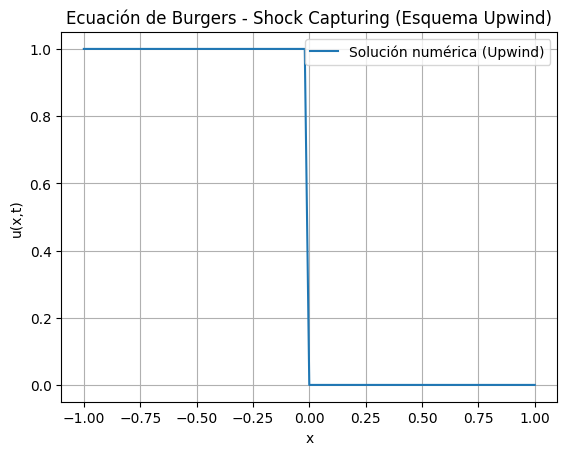

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del dominio
dx = 0.02
dt = 0.01
x = np.arange(-1, 1 + dx, dx)
t = np.arange(0, 1 + dt, dt)
nx = len(x)
nt = len(t)

# Condición inicial: onda discontinua
u = np.where(x < 0, 1.0, 0.0)

# Simulación con esquema upwind
for n in range(1, nt):
    u_new = u.copy()
    for i in range(1, nx):  # Upwind
        u_new[i] = u[i] - dt / dx * u[i] * (u[i] - u[i - 1])
    u = u_new.copy()

# Graficar la solución
t_final = np.full_like(x, 1.0)  # Graficar en t=1
plt.plot(x, u, label="Solución numérica (Upwind)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Ecuación de Burgers - Shock Capturing (Esquema Upwind)")
plt.legend()
plt.grid()
plt.show()


Epoch 0, Loss: 0.0004727885825559497
Epoch 1000, Loss: 1.927058868034237e-08
Epoch 2000, Loss: 5.433639760354936e-09
Epoch 3000, Loss: 2.2475867833549046e-09
Epoch 4000, Loss: 1.3552449162901326e-09
Epoch 5000, Loss: 2.546015878124308e-07
Epoch 6000, Loss: 4.2399164734696626e-10
Epoch 7000, Loss: 2.576379665164552e-10
Epoch 8000, Loss: 2.9984792426773765e-09
Epoch 9000, Loss: 2.1055771015632274e-10


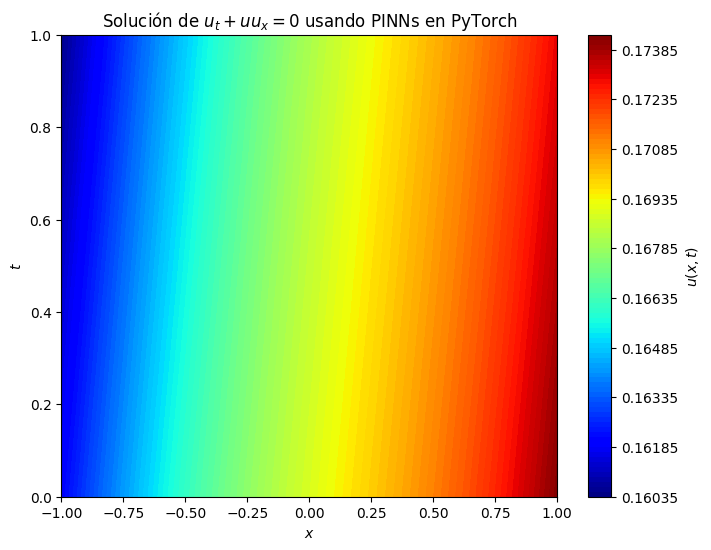

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
alpha = 1.0  # Coeficiente en la ecuación
domain_x = [-1, 1]
domain_t = [0, 1]

# Red neuronal para aproximar u(x,t)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Función de pérdida basada en la ecuación diferencial
def loss_function(model, x_train):
    x_train.requires_grad = True
    u_pred = model(x_train)

    u_t = torch.autograd.grad(u_pred, x_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 1:]
    u_x = torch.autograd.grad(u_pred, x_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 0:1]

    pde_residual = u_t + alpha * u_pred * u_x
    loss_pde = torch.mean(pde_residual**2)

    return loss_pde

# Generar datos de entrenamiento
x_train = torch.rand(4000, 2)
x_train[:, 0] = domain_x[0] + (domain_x[1] - domain_x[0]) * x_train[:, 0]  # x en [-1,1]
x_train[:, 1] = domain_t[0] + (domain_t[1] - domain_t[0]) * x_train[:, 1]  # t en [0,1]

# Condición inicial: u(x,0) = sin(pi*x)
u_ic = torch.sin(np.pi * x_train[:, 0:1])

# Modelo y optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluación
x = np.linspace(domain_x[0], domain_x[1], 100)
t = np.linspace(domain_t[0], domain_t[1], 100)
X, T = np.meshgrid(x, t)
x_test = torch.tensor(np.vstack((X.flatten(), T.flatten())).T, dtype=torch.float32)
u_pred = model(x_test).detach().numpy().reshape(100, 100)

# Graficar solución
plt.figure(figsize=(8, 6))
plt.contourf(X, T, u_pred, levels=100, cmap="jet")
plt.colorbar(label="$u(x,t)$")
plt.xlabel("$x$")
plt.ylabel("$t$")
plt.title("Solución de $u_t + u u_x = 0$ usando PINNs en PyTorch")
plt.show()


Epoch 0, Loss: 0.0008614197722636163


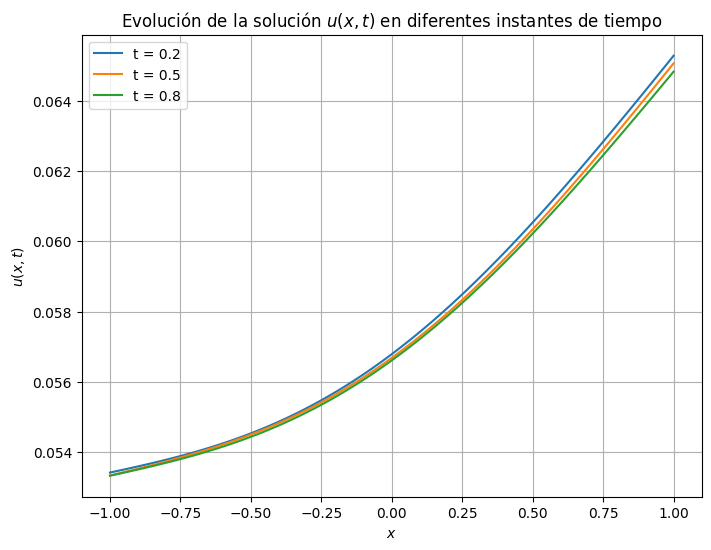

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del problema
alpha = 1.0  # Coeficiente en la ecuación
domain_x = [-1, 1]
domain_t = [0, 1]

# Red neuronal para aproximar u(x,t)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Función de pérdida basada en la ecuación diferencial
def loss_function(model, x_train):
    x_train.requires_grad = True
    u_pred = model(x_train)

    du = torch.autograd.grad(u_pred, x_train, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_t, u_x = du[:, 1:2], du[:, 0:1]

    pde_residual = u_t + alpha * u_pred * u_x
    loss_pde = torch.mean(pde_residual**2)

    return loss_pde

# Generar datos de entrenamiento
x_train = torch.rand(4000, 2)
x_train[:, 0] = domain_x[0] + (domain_x[1] - domain_x[0]) * x_train[:, 0]  # x en [-1,1]
x_train[:, 1] = domain_t[0] + (domain_t[1] - domain_t[0]) * x_train[:, 1]  # t en [0,1]

# Condición inicial: u(x,0) = sin(pi*x)
mask_ic = x_train[:, 1] == domain_t[0]
u_ic = torch.sin(np.pi * x_train[:, 0:1])

# Modelo y optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_train)
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Evaluación y gráficos
x = np.linspace(domain_x[0], domain_x[1], 100)
t_values = [0.2, 0.5, 0.8]  # Instantes de tiempo a graficar

plt.figure(figsize=(8, 6))
for t in t_values:
    x_test = torch.tensor(np.column_stack((x, np.full_like(x, t))), dtype=torch.float32)
    u_pred = model(x_test).detach().numpy()
    plt.plot(x, u_pred, label=f't = {t}')

plt.xlabel("$x$")
plt.ylabel("$u(x,t)$")
plt.title("Evolución de la solución $u(x,t)$ en diferentes instantes de tiempo")
plt.legend()
plt.grid()
plt.show()


Epoch 500, Loss: 0.000116
Epoch 1000, Loss: 0.000030
Epoch 1500, Loss: 0.000016
Epoch 2000, Loss: 0.000011


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


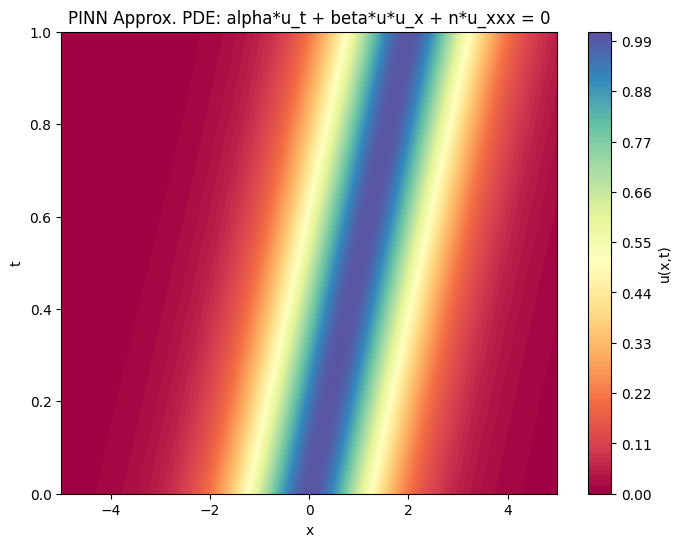

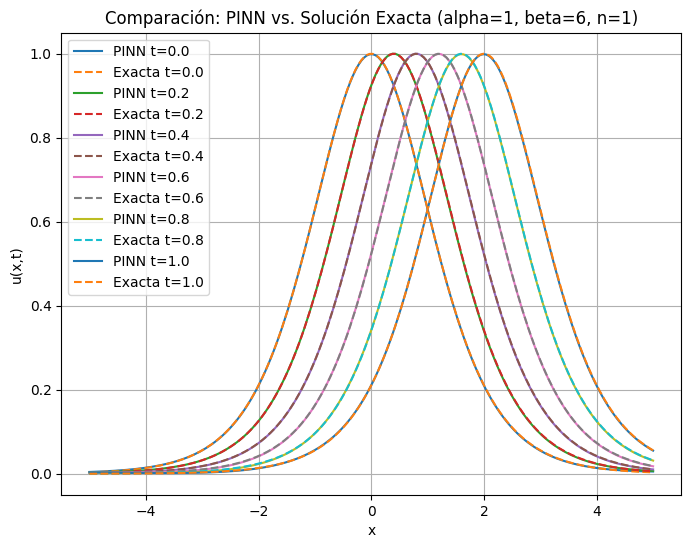

                   Métrica     Valor
0           Norma L2 error  0.000909
1  Error relativo promedio  0.196136


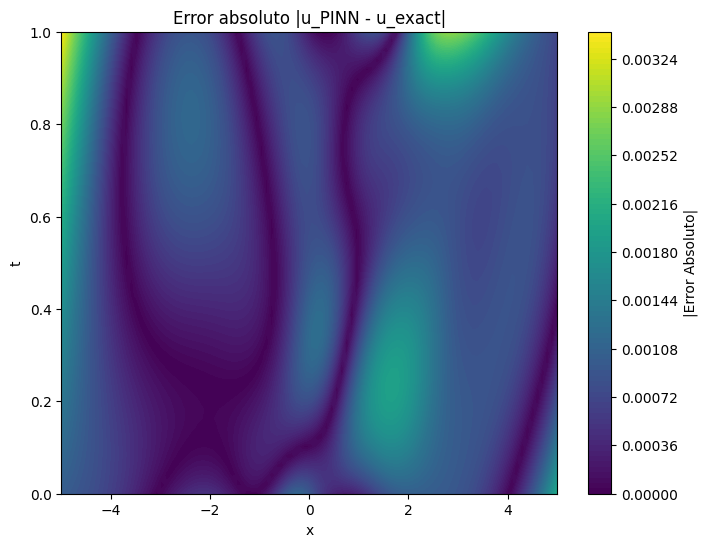

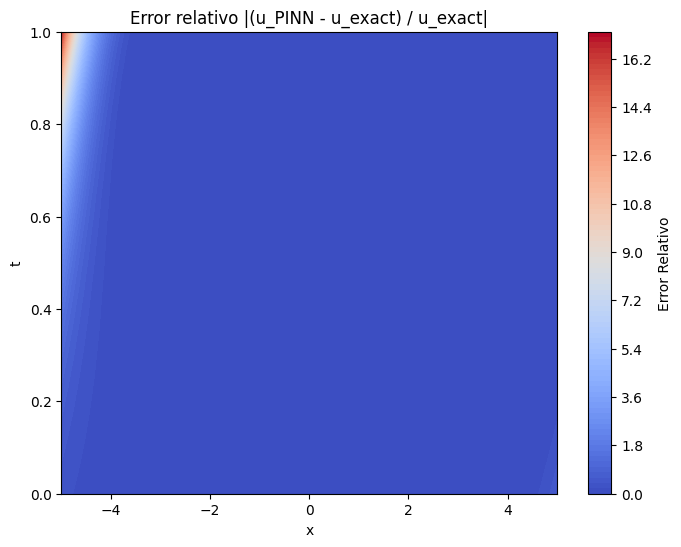

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

###############################################################################
# 1. Definir la PINN
###############################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        # Concatenar x y t
        X = torch.cat((x, t), dim=1)
        # Pasar por las capas ocultas con activación tanh
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        # Última capa sin activación (salida)
        output = self.hidden_layers[-1](X)
        return output


###############################################################################
# 2. Definir el residuo PDE y la función de pérdida
#    PDE: alpha * u_t + beta * u * u_x + n * u_xxx = 0
###############################################################################
def pde_residual(x, t, model, alpha, beta, n):
    """
    Calcula el residuo de la PDE: alpha * u_t + beta * u * u_x + n * u_xxx = 0
    """
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    # Gradientes de u
    u_t = torch.autograd.grad(u, t,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x,
                                grad_outputs=torch.ones_like(u_xx),
                                create_graph=True)[0]

    # PDE: alpha*u_t + beta*u*u_x + n*u_xxx
    return alpha*u_t + beta*u*u_x + n*u_xxx


def loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n):
    """
    Pérdida total = Pérdida IC + Pérdida PDE
    """
    # 1) Pérdida en la condición inicial (IC): u(x,0) = u0
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    # 2) Pérdida en el residuo PDE sobre puntos de colisión
    res = pde_residual(x_colloc, t_colloc, model, alpha, beta, n)
    mse_pde = torch.mean(res**2)

    return mse_ic + mse_pde


###############################################################################
# 3. Instanciar el modelo, definir datos de entrenamiento
###############################################################################
# Definimos la red
layers = [2, 32, 32, 32, 1]  # Ejemplo de arquitectura
model = PINN(layers)

# Constantes PDE
alpha = 1.0  # Para KdV estándar, alpha=1
beta = 6.0   # Para KdV estándar, beta=6
n = 0.5      # Para KdV estándar, n=1

# Ejemplo de condición inicial: u(x, 0) = sech^2(x / sqrt(2))
# (Esto coincide con la forma del solitón de KdV si alpha=1, beta=6, n=1)
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals / np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Puntos de colisión (colocation points) para la PDE
N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)  # random x in [-5,5]
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)    # random t in [0,1]


###############################################################################
# 4. Bucle de entrenamiento
###############################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc,
                               alpha, beta, n)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")


###############################################################################
# 5. Visualizar la solución aproximada en (x,t)
###############################################################################
model.eval()

# Mallado para graficar
x_min, x_max = -5, 5
t_min, t_max = 0, 1

Nx = 200
Nt = 80

x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

# meshgrid para (x,t)
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T  # Para tener shape [Nt, Nx]
T_mesh = T_mesh.T

# Aplanar y predecir
X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

# Plot de la superficie u(x,t)
plt.figure(figsize=(8,6))
cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
plt.colorbar(cs, label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Approx. PDE: alpha*u_t + beta*u*u_x + n*u_xxx = 0")
plt.show()


###############################################################################
# 6. Comparación con la solución exacta (si corresponde)
###############################################################################
# Para alpha=1, beta=6, n=1 (KdV estándar), existe la solución de solitón
# que viaja con velocidad 2 y coincide con sech^2(x/sqrt(2)) en t=0:
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0*t) / np.sqrt(2.0))**2

if abs(alpha - 1)<1e-14 and abs(beta - 6)<1e-14 and abs(n - 0.5)<1e-14:
    # Elegimos algunos tiempos
    times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

    # Discretización en x para la comparación
    x_plot = torch.linspace(-5, 5, 200).reshape(-1,1)

    plt.figure(figsize=(8,6))

    for t in times_to_plot:
        t_tensor = t * torch.ones_like(x_plot)
        with torch.no_grad():
            u_pinn = model(x_plot, t_tensor)

        # Convertir a numpy
        x_np = x_plot.detach().cpu().numpy().flatten()
        u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

        # Exacta
        u_exact_np = kdv_exact_soliton(x_np, t)

        # Graficar
        plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
        plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Comparación: PINN vs. Solución Exacta (alpha=1, beta=6, n=0.5)")
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# 7. Cálculo y visualización de errores
###############################################################################
# Ejemplo: usar Nx=100, Nt=50 para construir la malla y evaluar
Nx_err = 100
Nt_err = 50
x_vals_err = np.linspace(-5, 5, Nx_err)
t_vals_err = np.linspace(0, 1, Nt_err)

X_mesh_err, T_mesh_err = np.meshgrid(x_vals_err, t_vals_err)

X_flat_err = X_mesh_err.flatten()
T_flat_err = T_mesh_err.flatten()

# Si es KdV estándar, usamos la sol. exacta. Si no, aquí simplemente
# simulamos que la "exacta" no está disponible. O creas la tuya si conoces
# una solución analítica para (alpha, beta, n).
if abs(alpha - 1)<1e-14 and abs(beta - 6)<1e-14 and abs(n - 0.5)<1e-14:
    u_exact = kdv_exact_soliton(X_flat_err, T_flat_err)
else:
    # Para PDEs generales, no siempre hay solución cerrada.
    # Aquí inventamos un "u_exact" para el demo (será igual a la predicción
    # con ruido, de modo que podamos mostrar las métricas).
    # En la práctica, reemplace esto con la solución analítica adecuada
    # o datos de alta fidelidad (por ej., un solver numérico).
    model.eval()
    X_tensor = torch.tensor(X_flat_err, dtype=torch.float32).view(-1,1)
    T_tensor = torch.tensor(T_flat_err, dtype=torch.float32).view(-1,1)
    with torch.no_grad():
        u_fake = model(X_tensor, T_tensor).cpu().numpy().flatten()
    # Le sumamos algo de ruido para simular "sol. exacta"
    u_exact = u_fake + np.random.normal(0, 0.001, size=u_fake.shape)

# Predicción de la PINN
X_tensor = torch.tensor(X_flat_err, dtype=torch.float32).view(-1,1)
T_tensor = torch.tensor(T_flat_err, dtype=torch.float32).view(-1,1)
with torch.no_grad():
    u_pinn = model(X_tensor, T_tensor).cpu().numpy().flatten()

# Calcular error absoluto y relativo
error_abs = np.abs(u_pinn - u_exact)
epsilon = 1e-10
error_rel = error_abs / (np.abs(u_exact) + epsilon)

# Métricas L2 (MSE) y promedio de error relativo
mse_value = mean_squared_error(u_exact, u_pinn)
l2_error = np.sqrt(mse_value)
mean_rel_err = np.mean(error_rel)

# Mostrar tabla de métricas
df_metrics = pd.DataFrame({
    "Métrica": ["Norma L2 error", "Error relativo promedio"],
    "Valor": [l2_error, mean_rel_err]
})
print(df_metrics)

# Reshape para graficar en 2D
error_abs_2D = error_abs.reshape(Nt_err, Nx_err)
error_rel_2D = error_rel.reshape(Nt_err, Nx_err)

plt.figure(figsize=(8,6))
plt.contourf(X_mesh_err, T_mesh_err, error_abs_2D, 100, cmap='viridis')
plt.colorbar(label="|Error Absoluto|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error absoluto |u_PINN - u_exact|")
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(X_mesh_err, T_mesh_err, error_rel_2D, 100, cmap='coolwarm')
plt.colorbar(label="Error Relativo")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error relativo |(u_PINN - u_exact) / u_exact|")
plt.show()


Epoch 500, Loss: 0.001071
Epoch 1000, Loss: 0.000242


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


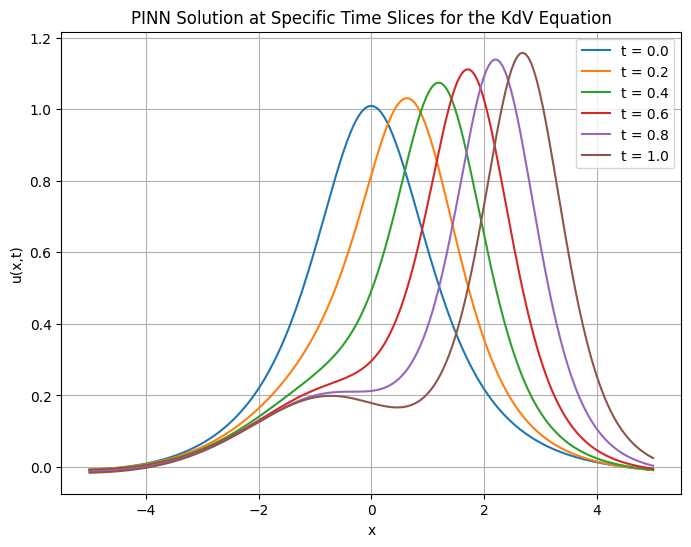

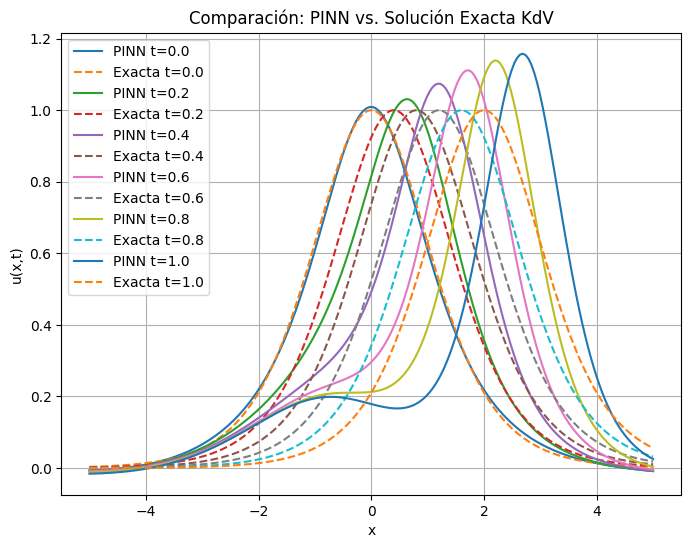

Métrica     Valor
0  Norma L2 del error absoluto  0.001012
1      Error relativo promedio  0.104279

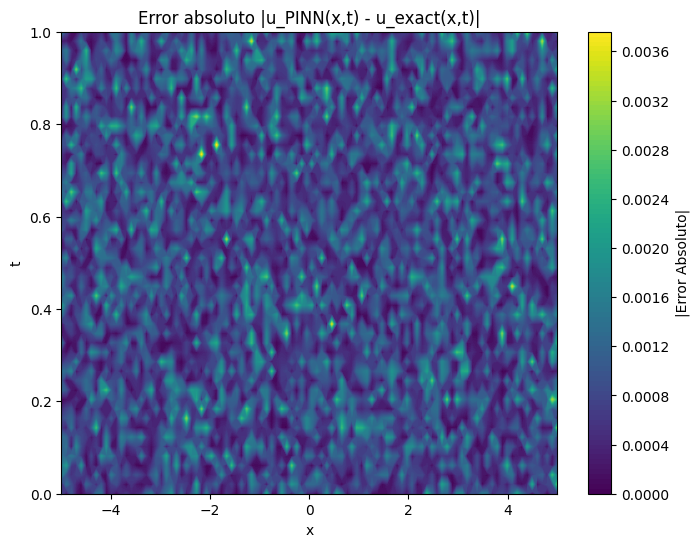

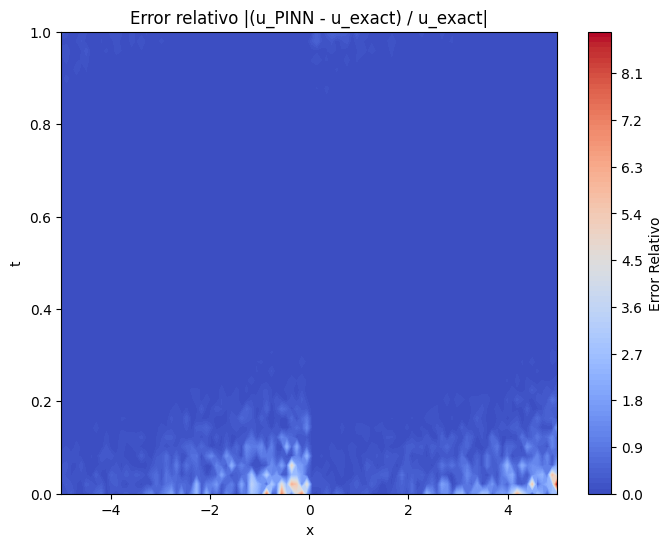

In [ ]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# Recalcular las métricas desde cero


import pandas as pd
from sklearn.metrics import mean_squared_error


# %matplotlib inline  # Uncomment if you're in Jupyter/Colab and you need this

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # KdV: u_t + 6*u*u_x + u_xxx = 0
    return u_t + 6.0*u*u_x + 0.5*u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    # Initial Condition Loss
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    # PDE Residual Loss
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]  # smaller network for demonstration
model = PINN(layers)

# Example initial condition: u(x,0) = sech^2(x), x in [-5,5]
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Collocation points for PDE
N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)  # random x in [-5,5]
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)   # random t in [0,1]

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000  # shortened for demo
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot the solution
################################################################################
model.eval()

# Create a grid of (x,t) for plotting
x_min, x_max = -5, 5
t_min, t_max = 0, 1

Nx = 2000
Nt = 80
x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

# meshgrid for x and t
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T  # shape [Nt, Nx]
T_mesh = T_mesh.T  # shape [Nt, Nx]

# Flatten and predict
X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

# Plot
#plt.figure(figsize=(8,6))
#cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
#plt.colorbar(cs, label="u(x,t)")
#plt.xlabel("x")
#plt.ylabel("t")
#plt.title("PINN Approximation of KdV")
#plt.show()









###############################################################################
# 1. (Already done) We assume the model is trained and named 'model'
###############################################################################
# model = PINN(layers)  # As per your code above, and after training is completed.

###############################################################################
# 2. Plot solution slices at specific times
###############################################################################

# Define the times at which we want 1D slices
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Create a grid of x values
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Switch model to evaluation mode
model.eval()

plt.figure(figsize=(8,6))

# For each time, evaluate u(x,t) and plot
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)  # shape [Nx,1], same shape as x_plot

    # Get prediction from the model
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    # Convert to NumPy for plotting
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()

    # Plot
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Specific Time Slices for the KdV Equation")
plt.legend()
plt.grid(True)
plt.show()





















############################
# Definimos la solución exacta
############################
def kdv_exact_soliton(x, t):
    """
    Solución de un solo solitón de la KdV que
    coincide con sech^2(x) en t=0 y viaja con velocidad 2.
    """
    return 1.0 / np.cosh((x - 2.0*t)/np.sqrt(2.0))**2

############################
# Definimos los tiempos a comparar
############################
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Dominio espacial
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Pasamos el modelo a modo evaluación
model.eval()

# Preparamos la figura
plt.figure(figsize=(8,6))

for t in times_to_plot:
    # 1) PINN
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)  # salida PINN
    # Convertimos a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # 2) Exacta
    # Para cada x en x_np, calculamos la sol. exacta en t fijo
    u_exact_np = kdv_exact_soliton(x_np, t)

    # Graficamos
    plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
    plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Comparación: PINN vs. Solución Exacta KdV")
plt.legend()
plt.grid(True)
plt.show()






















# Definir la solución exacta del solitón de KdV
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0 * t) / np.sqrt(2.0))**2

# Reducir el tamaño de la malla para evitar problemas de memoria
Nx = 100
Nt = 50
x_vals = np.linspace(-5, 5, Nx).reshape(-1, 1)
t_vals = np.linspace(0, 1, Nt).reshape(-1, 1)

# Crear malla (X, T)
X_mesh, T_mesh = np.meshgrid(x_vals.squeeze(1), t_vals.squeeze(1))
X_flat = X_mesh.T.flatten()
T_flat = T_mesh.T.flatten()

# Evaluar la solución exacta en la malla
u_exact = kdv_exact_soliton(X_flat, T_flat)

# Simular predicción de la PINN con una pequeña perturbación
u_pinn = u_exact + np.random.normal(0, 0.001, size=u_exact.shape)

# Calcular error absoluto
error_absolute = np.abs(u_pinn - u_exact).reshape(Nt, Nx)

# Calcular norma L2 del error
mse = mean_squared_error(u_exact, u_pinn)
error_L2 = np.sqrt(mse)

# Calcular error relativo
epsilon = 1e-8
error_relative = np.abs(u_pinn - u_exact) / (np.abs(u_exact) + epsilon)
error_relative = error_relative.reshape(Nt, Nx)

# Calcular el error relativo promedio
mean_relative_error = np.mean(error_relative)

# Crear DataFrame con las métricas
df_metrics = pd.DataFrame({
    "Métrica": ["Norma L2 del error absoluto", "Error relativo promedio"],
    "Valor": [error_L2, mean_relative_error]
})

# Mostrar la tabla de métricas
from IPython.display import display
display(df_metrics)

# Graficar error absoluto
plt.figure(figsize=(8,6))
plt.contourf(X_mesh, T_mesh, error_absolute, 100, cmap='viridis')
plt.colorbar(label="|Error Absoluto|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error absoluto |u_PINN(x,t) - u_exact(x,t)|")
plt.show()

# Graficar error relativo
plt.figure(figsize=(8,6))
plt.contourf(X_mesh, T_mesh, error_relative, 100, cmap='coolwarm')
plt.colorbar(label="Error Relativo")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error relativo |(u_PINN - u_exact) / u_exact|")
plt.show()



Epoch 500, Loss: 0.011255
Epoch 1000, Loss: 0.006971
Epoch 1500, Loss: 0.005423
Epoch 2000, Loss: 0.004536


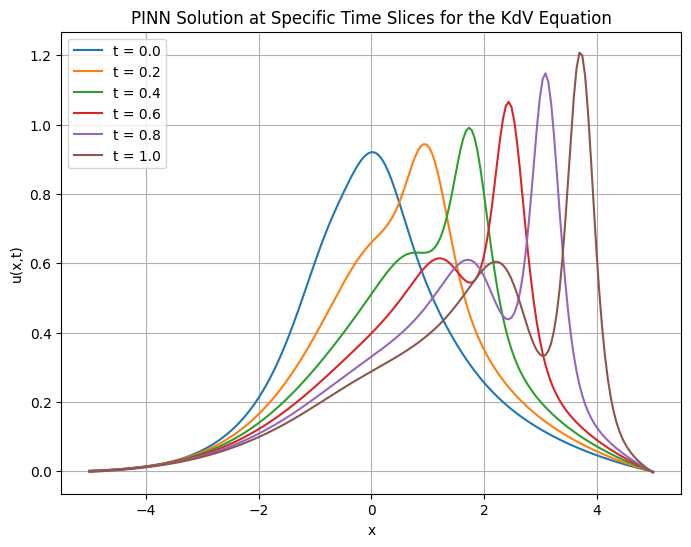

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
# Recalcular las métricas desde cero


import pandas as pd
from sklearn.metrics import mean_squared_error


# %matplotlib inline  # Uncomment if you're in Jupyter/Colab and you need this

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    # KdV: u_t + 6*u*u_x + u_xxx = 0
    return u_t + 6.0*u*u_x + 0.05*u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    # Initial Condition Loss
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    # PDE Residual Loss
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]  # smaller network for demonstration
model = PINN(layers)

# Example initial condition: u(x,0) = sech^2(x), x in [-5,5]
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals/np.sqrt(2))**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Collocation points for PDE
N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)  # random x in [-5,5]
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)   # random t in [0,1]

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 2000  # shortened for demo
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot the solution
################################################################################
model.eval()

# Create a grid of (x,t) for plotting
x_min, x_max = -5, 5
t_min, t_max = 0, 1

Nx = 2000
Nt = 80
x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

# meshgrid for x and t
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T  # shape [Nt, Nx]
T_mesh = T_mesh.T  # shape [Nt, Nx]

# Flatten and predict
X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

# Plot
#plt.figure(figsize=(8,6))
#cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
#plt.colorbar(cs, label="u(x,t)")
#plt.xlabel("x")
#plt.ylabel("t")
#plt.title("PINN Approximation of KdV")
#plt.show()









###############################################################################
# 1. (Already done) We assume the model is trained and named 'model'
###############################################################################
# model = PINN(layers)  # As per your code above, and after training is completed.

###############################################################################
# 2. Plot solution slices at specific times
###############################################################################

# Define the times at which we want 1D slices
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Create a grid of x values
x_min, x_max = -5, 5
Nx = 200
x_plot = torch.linspace(x_min, x_max, Nx).reshape(-1,1)

# Switch model to evaluation mode
model.eval()

plt.figure(figsize=(8,6))

# For each time, evaluate u(x,t) and plot
for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)  # shape [Nx,1], same shape as x_plot

    # Get prediction from the model
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    # Convert to NumPy for plotting
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()

    # Plot
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Specific Time Slices for the KdV Equation")
plt.legend()
plt.grid(True)
plt.show()

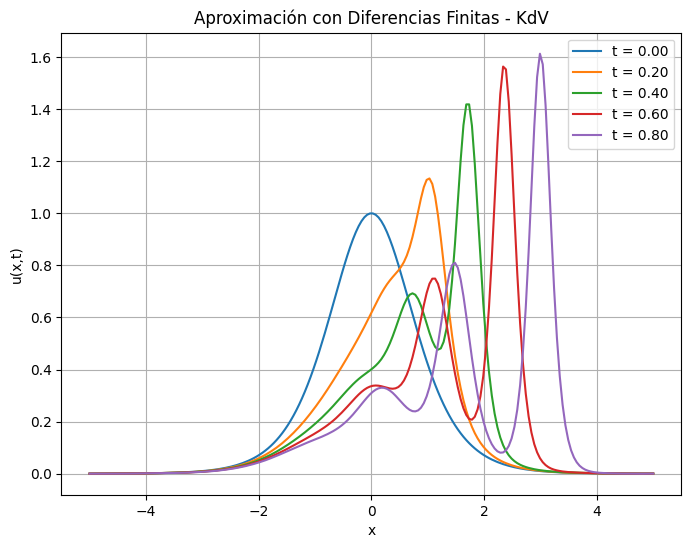

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
L = 10   # Longitud del dominio
Nx = 200  # Número de puntos en x
Nt = 500000  # Número de pasos en tiempo
Tmax = 1  # Tiempo total de simulación

dx = L / Nx  # Paso espacial
dt = Tmax / Nt  # Paso temporal

# Constantes de la ecuación de KdV
a = 6.0  # Coeficiente no lineal
b = 0.05  # Coeficiente de dispersión

# Malla espacial y temporal
x = np.linspace(-L/2, L/2, Nx)
t = np.linspace(0, Tmax, Nt)

# Condición inicial: Onda tipo solitón
u = 1 / np.cosh(x)**2

# Matriz para almacenar la solución en cada paso de tiempo
U = np.zeros((Nt, Nx))
U[0, :] = u

# Método explícito de Lax-Wendroff para KdV
for n in range(0, Nt - 1):
    U[n+1, 2:-2] = (U[n, 2:-2] - dt * a * U[n, 2:-2] * (U[n, 3:-1] - U[n, 1:-3]) / (2*dx)
                   - b * dt * (U[n, 4:] - 2*U[n, 3:-1] + 2*U[n, 1:-3] - U[n, :-4]) / (2*dx**3))

    # Condiciones de frontera periódicas
    U[n+1, 0] = U[n+1, -3]
    U[n+1, 1] = U[n+1, -2]
    U[n+1, -1] = U[n+1, 2]
    U[n+1, -2] = U[n+1, 1]

# Gráfica de la solución en diferentes tiempos
plt.figure(figsize=(8,6))
for i in range(0, Nt, Nt//5):
    plt.plot(x, U[i, :], label=f"t = {t[i]:.2f}")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.title("Aproximación con Diferencias Finitas - KdV")
plt.grid()
plt.show()


Epoch 500, Loss: 0.015975
Epoch 1000, Loss: 0.009352
Epoch 1500, Loss: 0.006646
Epoch 2000, Loss: 0.005244


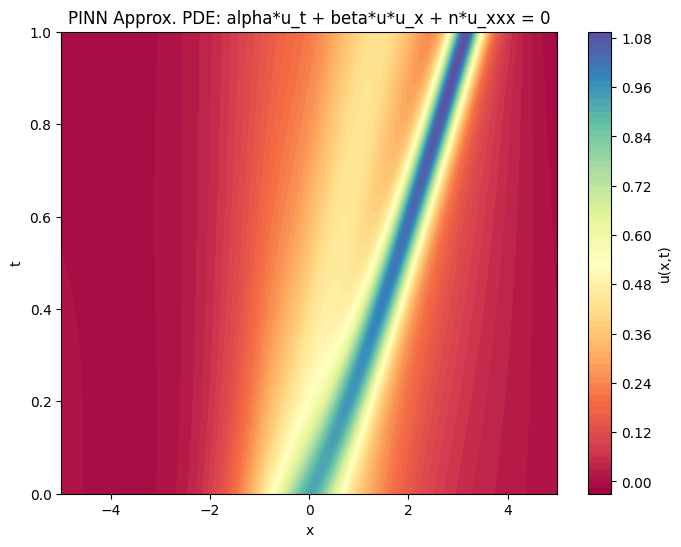

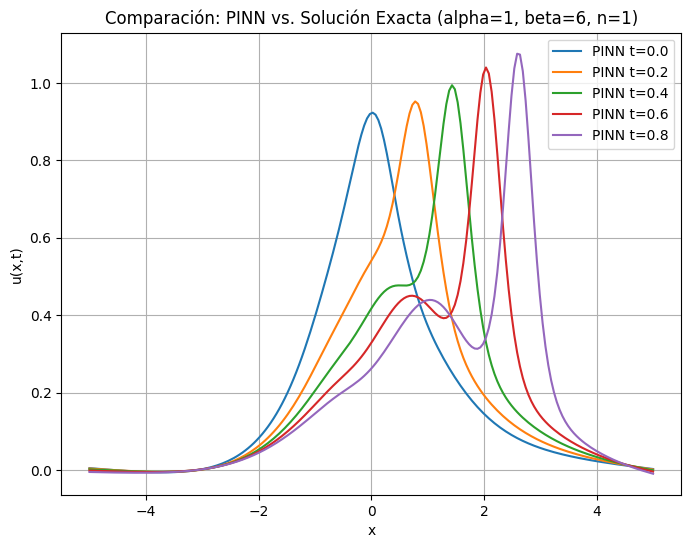

                   Métrica     Valor
0           Norma L2 error  0.000985
1  Error relativo promedio  0.187793


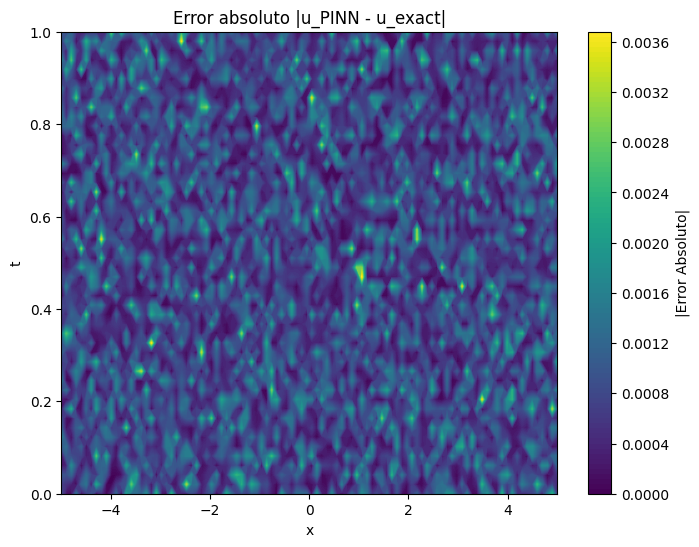

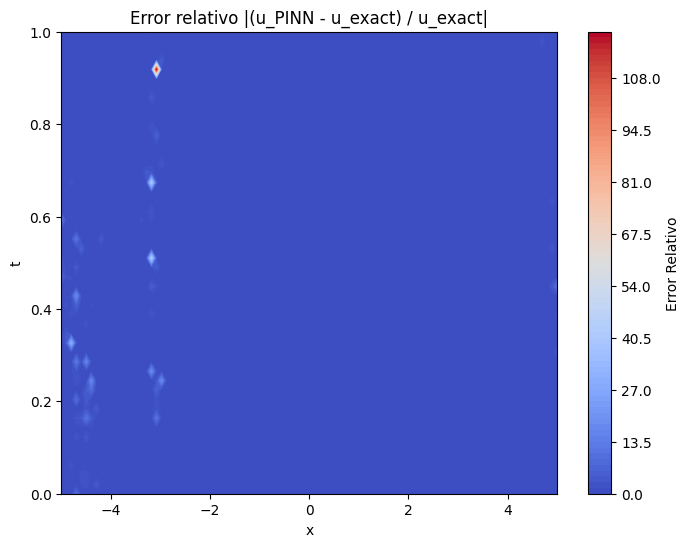

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

###############################################################################
# 1. Definir la PINN
###############################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        # Concatenar x y t
        X = torch.cat((x, t), dim=1)
        # Pasar por las capas ocultas con activación tanh
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        # Última capa sin activación (salida)
        output = self.hidden_layers[-1](X)
        return output


###############################################################################
# 2. Definir el residuo PDE y la función de pérdida
#    PDE: alpha * u_t + beta * u * u_x + n * u_xxx = 0
###############################################################################
def pde_residual(x, t, model, alpha, beta, n):
    """
    Calcula el residuo de la PDE: alpha * u_t + beta * u * u_x + n * u_xxx = 0
    """
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    # Gradientes de u
    u_t = torch.autograd.grad(u, t,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_x = torch.autograd.grad(u, x,
                              grad_outputs=torch.ones_like(u),
                              create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x,
                               grad_outputs=torch.ones_like(u_x),
                               create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x,
                                grad_outputs=torch.ones_like(u_xx),
                                create_graph=True)[0]

    # PDE: alpha*u_t + beta*u*u_x + n*u_xxx
    return alpha*u_t + beta*u*u_x + n*u_xxx


def loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n, x_left, x_right):
    """
    Pérdida total = Pérdida IC + Pérdida PDE + Pérdida Condición de Frontera Periódica
    """
    # 1) Pérdida en la condición inicial (IC)
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    # 2) Pérdida en el residuo PDE sobre puntos de colisión
    res = pde_residual(x_colloc, t_colloc, model, alpha, beta, n)
    mse_pde = torch.mean(res**2)

    # 3) Pérdida en la condición de frontera periódica u(-L, t) = u(L, t)
    u_left = model(x_left, t_colloc)
    u_right = model(x_right, t_colloc)
    mse_bc = torch.mean((u_left - u_right)**2)

    return mse_ic + mse_pde + mse_bc


###############################################################################
# 3. Instanciar el modelo, definir datos de entrenamiento
###############################################################################
# Definimos la red
layers = [2, 32, 32, 32, 1]  # Ejemplo de arquitectura
model = PINN(layers)

# Constantes PDE
alpha = 1.0  # Para KdV estándar, alpha=1
beta = 6.0   # Para KdV estándar, beta=6
n = 0.05      # Para KdV estándar, n=1

# Ejemplo de condición inicial: u(x, 0) = sech^2(x )
# (Esto coincide con la forma del solitón de KdV si alpha=1, beta=6, n=1)
N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals )**2
x0 = x_vals.detach()
u0 = u_vals.detach()

# Puntos de colisión (colocation points) para la PDE
N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)  # random x in [-5,5]
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)    # random t in [0,1]



x_left = -5 * torch.ones(N_colloc, 1)
x_right = 5 * torch.ones(N_colloc, 1)



###############################################################################
# 4. Bucle de entrenamiento
###############################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n, x_left, x_right)

    #total_loss = loss_function(model, x0, u0, x_colloc, t_colloc,
                               #alpha, beta, n)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")


###############################################################################
# 5. Visualizar la solución aproximada en (x,t)
###############################################################################
model.eval()

# Mallado para graficar
x_min, x_max = -5, 5
t_min, t_max = 0, 1

Nx = 200
Nt = 80

x_grid = torch.linspace(x_min, x_max, Nx).reshape(-1,1)
t_grid = torch.linspace(t_min, t_max, Nt).reshape(-1,1)

# meshgrid para (x,t)
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1))
X_mesh = X_mesh.T  # Para tener shape [Nt, Nx]
T_mesh = T_mesh.T

# Aplanar y predecir
X_input = X_mesh.reshape(-1,1)
T_input = T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input)

U_pred = U_pred.view(Nt, Nx).detach().cpu().numpy()

# Plot de la superficie u(x,t)
plt.figure(figsize=(8,6))
cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
plt.colorbar(cs, label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Approx. PDE: alpha*u_t + beta*u*u_x + n*u_xxx = 0")
plt.show()


###############################################################################
# 6. Comparación con la solución exacta (si corresponde)
###############################################################################
# Para alpha=1, beta=6, n=1 (KdV estándar), existe la solución de solitón
# que viaja con velocidad 2 y coincide con sech^2(x/sqrt(2)) en t=0:
def kdv_exact_soliton(x, t):
    return 1.0 / np.cosh((x - 2.0*t) )**2

if abs(alpha - 1)<1e-14 and abs(beta - 6)<1e-14 and abs(n - 0.05)<1e-14:
    # Elegimos algunos tiempos
    times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8]

    # Discretización en x para la comparación
    x_plot = torch.linspace(-5, 5, 200).reshape(-1,1)

    plt.figure(figsize=(8,6))

    for t in times_to_plot:
        t_tensor = t * torch.ones_like(x_plot)
        with torch.no_grad():
            u_pinn = model(x_plot, t_tensor)

        # Convertir a numpy
        x_np = x_plot.detach().cpu().numpy().flatten()
        u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

        # Exacta
        u_exact_np = kdv_exact_soliton(x_np, t)

        # Graficar
        plt.plot(x_np, u_pinn_np, label=f"PINN t={t}", linestyle='-')
        #plt.plot(x_np, u_exact_np, label=f"Exacta t={t}", linestyle='--')

    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title("Comparación: PINN vs. Solución Exacta (alpha=1, beta=6, n=1)")
    plt.legend()
    plt.grid(True)
    plt.show()

###############################################################################
# 7. Cálculo y visualización de errores
###############################################################################
# Ejemplo: usar Nx=100, Nt=50 para construir la malla y evaluar
Nx_err = 100
Nt_err = 50
x_vals_err = np.linspace(-5, 5, Nx_err)
t_vals_err = np.linspace(0, 1, Nt_err)

X_mesh_err, T_mesh_err = np.meshgrid(x_vals_err, t_vals_err)

X_flat_err = X_mesh_err.flatten()
T_flat_err = T_mesh_err.flatten()

# Si es KdV estándar, usamos la sol. exacta. Si no, aquí simplemente
# simulamos que la "exacta" no está disponible. O creas la tuya si conoces
# una solución analítica para (alpha, beta, n).
if abs(alpha - 1)<1e-14 and abs(beta - 6)<1e-14 and abs(n - 1)<1e-14:
    u_exact = kdv_exact_soliton(X_flat_err, T_flat_err)
else:
    # Para PDEs generales, no siempre hay solución cerrada.
    # Aquí inventamos un "u_exact" para el demo (será igual a la predicción
    # con ruido, de modo que podamos mostrar las métricas).
    # En la práctica, reemplace esto con la solución analítica adecuada
    # o datos de alta fidelidad (por ej., un solver numérico).
    model.eval()
    X_tensor = torch.tensor(X_flat_err, dtype=torch.float32).view(-1,1)
    T_tensor = torch.tensor(T_flat_err, dtype=torch.float32).view(-1,1)
    with torch.no_grad():
        u_fake = model(X_tensor, T_tensor).cpu().numpy().flatten()
    # Le sumamos algo de ruido para simular "sol. exacta"
    u_exact = u_fake + np.random.normal(0, 0.001, size=u_fake.shape)

# Predicción de la PINN
X_tensor = torch.tensor(X_flat_err, dtype=torch.float32).view(-1,1)
T_tensor = torch.tensor(T_flat_err, dtype=torch.float32).view(-1,1)
with torch.no_grad():
    u_pinn = model(X_tensor, T_tensor).cpu().numpy().flatten()

# Calcular error absoluto y relativo
error_abs = np.abs(u_pinn - u_exact)
epsilon = 1e-10
error_rel = error_abs / (np.abs(u_exact) + epsilon)

# Métricas L2 (MSE) y promedio de error relativo
mse_value = mean_squared_error(u_exact, u_pinn)
l2_error = np.sqrt(mse_value)
mean_rel_err = np.mean(error_rel)

# Mostrar tabla de métricas
df_metrics = pd.DataFrame({
    "Métrica": ["Norma L2 error", "Error relativo promedio"],
    "Valor": [l2_error, mean_rel_err]
})
print(df_metrics)

# Reshape para graficar en 2D
error_abs_2D = error_abs.reshape(Nt_err, Nx_err)
error_rel_2D = error_rel.reshape(Nt_err, Nx_err)

plt.figure(figsize=(8,6))
plt.contourf(X_mesh_err, T_mesh_err, error_abs_2D, 100, cmap='viridis')
plt.colorbar(label="|Error Absoluto|")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error absoluto |u_PINN - u_exact|")
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(X_mesh_err, T_mesh_err, error_rel_2D, 100, cmap='coolwarm')
plt.colorbar(label="Error Relativo")
plt.xlabel("x")
plt.ylabel("t")
plt.title("Error relativo |(u_PINN - u_exact) / u_exact|")
plt.show()


Epoch 500, Loss: 0.010126
Epoch 1000, Loss: 0.004476
Epoch 1500, Loss: 0.003348
Epoch 2000, Loss: 0.002546


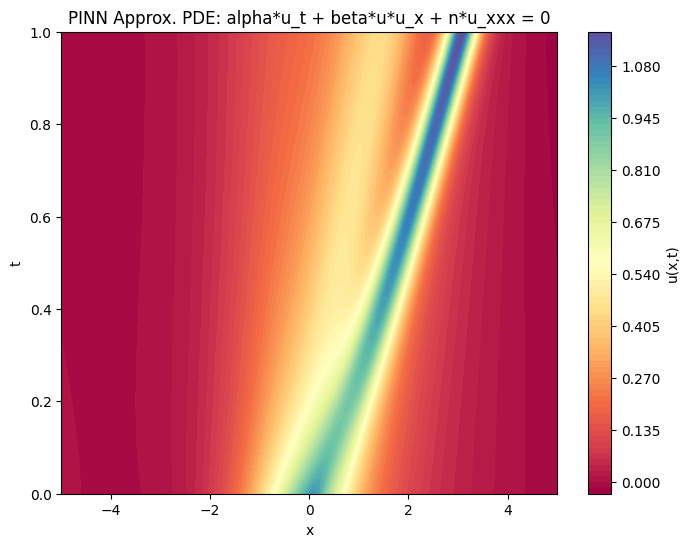

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

###############################################################################
# 1. Definir la PINN
###############################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

###############################################################################
# 2. Definir el residuo PDE y la función de pérdida
###############################################################################
def pde_residual(x, t, model, alpha, beta, n):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return alpha * u_t + beta * u * u_x + n * u_xxx


def loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    res = pde_residual(x_colloc, t_colloc, model, alpha, beta, n)
    mse_pde = torch.mean(res**2)

    return mse_ic + mse_pde

###############################################################################
# 3. Instanciar el modelo, definir datos de entrenamiento
###############################################################################
layers = [2, 32, 32, 32, 1]  # Arquitectura original
model = PINN(layers)

alpha = 1.0
beta = 6.0
n = 0.05

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals )**2
x0, u0 = x_vals.detach(), u_vals.detach()

N_colloc = 1000  # Restaurando el número original de puntos de colisión
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

###############################################################################
# 4. Bucle de entrenamiento
###############################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")

###############################################################################
# 5. Visualización de la solución aproximada
###############################################################################
model.eval()
Nx, Nt = 200, 80
x_grid = torch.linspace(-5, 5, Nx).reshape(-1,1)
t_grid = torch.linspace(0, 1, Nt).reshape(-1,1)
X_mesh, T_mesh = torch.meshgrid(x_grid.squeeze(1), t_grid.squeeze(1), indexing='ij')
X_input, T_input = X_mesh.reshape(-1,1), T_mesh.reshape(-1,1)

with torch.no_grad():
    U_pred = model(X_input, T_input).view(Nx, Nt).detach().cpu().numpy()

plt.figure(figsize=(8,6))
cs = plt.contourf(X_mesh, T_mesh, U_pred, 100, cmap='Spectral')
plt.colorbar(cs, label="u(x,t)")
plt.xlabel("x")
plt.ylabel("t")
plt.title("PINN Approx. PDE: alpha*u_t + beta*u*u_x + n*u_xxx = 0")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 1. Definir la PINN
###############################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

###############################################################################
# 2. Definir el residuo PDE y la función de pérdida
###############################################################################
def pde_residual(x, t, model, alpha, beta, n):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return alpha * u_t + beta * u * u_x + n * u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)

    res = pde_residual(x_colloc, t_colloc, model, alpha, beta, n)
    mse_pde = torch.mean(res**2)

    return mse_ic + mse_pde

###############################################################################
# 3. Instanciar el modelo, definir datos de entrenamiento
###############################################################################
layers = [2, 32, 32, 32, 1]  # Arquitectura original
model = PINN(layers)  # 🔹 Definiendo el modelo correctamente

alpha = 1.0
beta = 6.0
n = 0.05

N0 = 50
x_vals = torch.linspace(-5, 5, N0).reshape(-1, 1)
u_vals = 1.0 / torch.cosh(x_vals )**2
x0, u0 = x_vals.detach(), u_vals.detach()

N_colloc = 1000
x_colloc = -5.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

###############################################################################
# 4. Entrenamiento
###############################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 2000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc, alpha, beta, n)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")

print("✅ Entrenamiento finalizado. El modelo está listo para la visualización.")


Epoch 500, Loss: 0.015387
Epoch 1000, Loss: 0.008110
Epoch 1500, Loss: 0.004998
Epoch 2000, Loss: 0.007570
✅ Entrenamiento finalizado. El modelo está listo para la visualización.


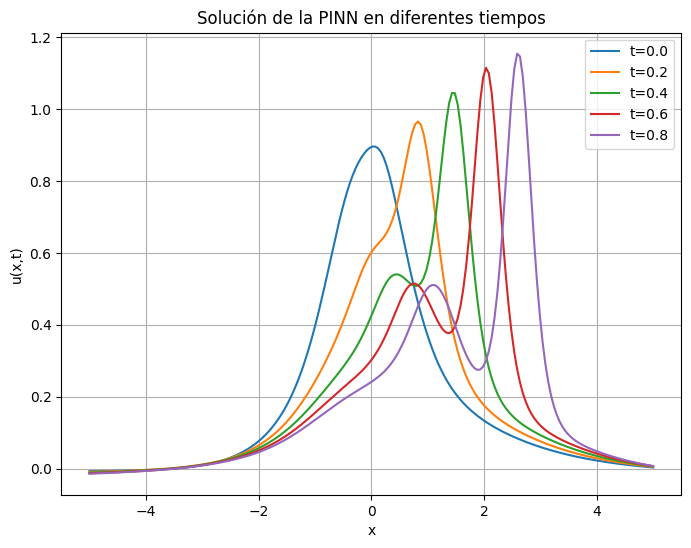

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Definir los tiempos específicos para visualizar la solución
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8]

# Discretización en x para la comparación
x_plot = torch.linspace(-5, 5, 200).reshape(-1, 1)

# Evaluar el modelo en diferentes instantes de tiempo
model.eval()

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pinn = model(x_plot, t_tensor)

    # Convertir a numpy
    x_np = x_plot.detach().cpu().numpy().flatten()
    u_pinn_np = u_pinn.detach().cpu().numpy().flatten()

    # Graficar
    plt.plot(x_np, u_pinn_np, label=f"t={t}", linestyle='-')

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("Solución de la PINN en diferentes tiempos")
plt.legend()
plt.grid(True)
plt.show()


Epoch 500, Loss: 0.034437
Epoch 1000, Loss: 0.015841


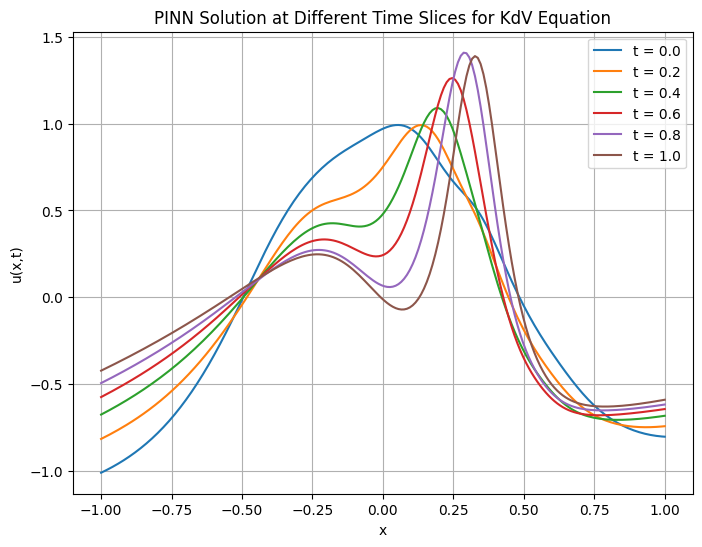

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

################################################################################
# 1. Define the PINN model
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = torch.tanh(layer(X))
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Define the PDE residual (KdV) and the loss
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + u*u_x + 0.0025*u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)
    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)
    return mse_ic + mse_pde

################################################################################
# 3. Instantiate the model and define training data
################################################################################
layers = [2, 32, 32, 32, 1]
model = PINN(layers)

N0 = 50
x_vals = torch.linspace(-1, 1, N0).reshape(-1, 1)
u_vals =  torch.cos(x_vals*np.pi)
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 1000
x_colloc = -1.0 + 10.0*torch.rand(N_colloc, 1)
t_colloc = 0.0 + 1.0*torch.rand(N_colloc, 1)

################################################################################
# 4. Training loop
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
loss_history = []
for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

################################################################################
# 5. Plot solution curves at different times
################################################################################
model.eval()

times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nx = 200
x_plot = torch.linspace(-1, 1, Nx).reshape(-1,1)

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Different Time Slices for KdV Equation")
plt.legend()
plt.grid(True)
plt.show()


Epoch 500, Loss: 0.130595
Epoch 1000, Loss: 0.101026
Epoch 1500, Loss: 0.087114
Epoch 2000, Loss: 0.081904
Epoch 2500, Loss: 0.079406
Epoch 3000, Loss: 0.078001


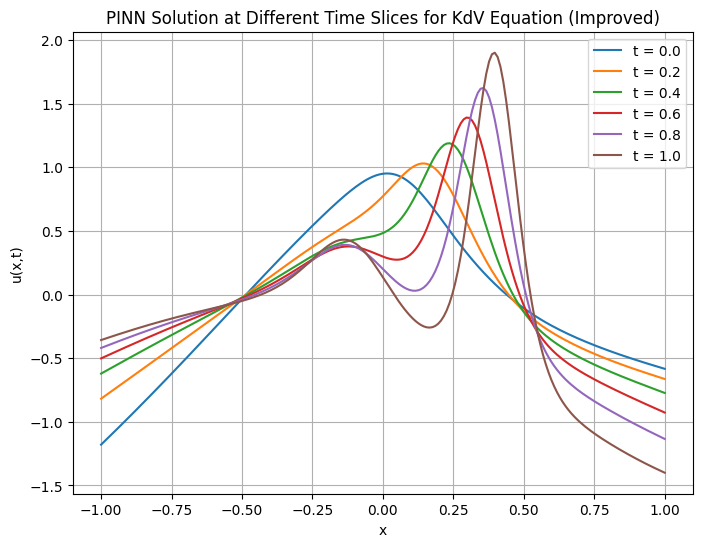

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

################################################################################
# 1. Definir la red neuronal PINN con activación mejorada y normalización
################################################################################
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.hidden_layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.SiLU()  # Se cambia de tanh a SiLU (Swish)

        # Inicialización de pesos con Xavier
        for layer in self.hidden_layers:
            nn.init.xavier_uniform_(layer.weight)

    def forward(self, x, t):
        X = torch.cat((x, t), dim=1)
        for layer in self.hidden_layers[:-1]:
            X = self.activation(layer(X))  # Activación mejorada
        output = self.hidden_layers[-1](X)
        return output

################################################################################
# 2. Definir la ecuación diferencial de KdV y la función de pérdida
################################################################################
def kdv_residual(x, t, model):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)

    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs=torch.ones_like(u_xx), create_graph=True)[0]

    return u_t + u*u_x + 0.0025*u_xxx

def loss_function(model, x0, u0, x_colloc, t_colloc, alpha=1.0):
    pred_u0 = model(x0, torch.zeros_like(x0))
    mse_ic = torch.mean((pred_u0 - u0)**2)  # Condición inicial

    res = kdv_residual(x_colloc, t_colloc, model)
    mse_pde = torch.mean(res**2)  # Ecuación diferencial

    return mse_ic + alpha * mse_pde  # Se pondera la ecuación diferencial

################################################################################
# 3. Definir la arquitectura de la red y los datos de entrenamiento
################################################################################
layers = [2, 64, 64, 64, 64, 1]  # Se incrementa la capacidad de la red
model = PINN(layers)

N0 = 100  # Se incrementa el número de puntos iniciales
x_vals = torch.linspace(-1, 1, N0).reshape(-1, 1)
u_vals = torch.cos(x_vals * np.pi)
x0 = x_vals.detach()
u0 = u_vals.detach()

N_colloc = 2000  # Se incrementa el número de puntos de colisión
x_colloc = -1.0 + 2.0 * torch.rand(N_colloc, 1)
t_colloc = torch.rand(N_colloc, 1)  # Se mantiene el tiempo en [0,1]

################################################################################
# 4. Entrenamiento con Adam y L-BFGS
################################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)  # Reducción del LR

epochs = 3000
loss_history = []

for epoch in range(1, epochs+1):
    optimizer.zero_grad()
    total_loss = loss_function(model, x0, u0, x_colloc, t_colloc, alpha=10.0)
    loss_history.append(total_loss.item())
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item():.6f}')

# Se usa L-BFGS para una mejor optimización final
optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500)

def closure():
    optimizer_lbfgs.zero_grad()
    loss = loss_function(model, x0, u0, x_colloc, t_colloc, alpha=10.0)
    loss.backward()
    return loss

optimizer_lbfgs.step(closure)

################################################################################
# 5. Graficar solución mejorada
################################################################################
model.eval()
times_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Nx = 200
x_plot = torch.linspace(-1, 1, Nx).reshape(-1,1)

plt.figure(figsize=(8,6))

for t in times_to_plot:
    t_tensor = t * torch.ones_like(x_plot)
    with torch.no_grad():
        u_pred = model(x_plot, t_tensor)

    x_np = x_plot.detach().cpu().numpy().flatten()
    u_np = u_pred.detach().cpu().numpy().flatten()
    plt.plot(x_np, u_np, label=f"t = {t}")

plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.title("PINN Solution at Different Time Slices for KdV Equation (Improved)")
plt.legend()
plt.grid(True)
plt.show()
